In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/home/youlee/n24news/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EPOCHS = 10
BATCH_SIZE = 32
K_FOLDS = 5
MAX_LENGTH = 128
CATEGORIES = [
    "Opinion", "Art & Design", "Television", "Music", "Travel",
    "Real Estate", "Books", "Theater", "Health", "Sports",
    "Science", "Food", "Fashion & Style", "Movies", "Technology",
    "Dance", "Media", "Style"
]

In [3]:
file_path = '/home/youlee/n24news/n24news/captions_and_labels.csv'
data = pd.read_csv(file_path)
data = data[data['Label'].isin(CATEGORIES)]
label_groups = [CATEGORIES[i:i + 3] for i in range(0, len(CATEGORIES), 3)]

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

In [6]:
def tokenize_data(df):
    input_ids, attention_masks = [], []
    df['Caption'] = df['Caption'].astype(str).fillna("")

    for text in df['Caption']:
        encoded = tokenizer(
            text, padding='max_length', truncation=True, max_length=MAX_LENGTH, return_tensors="pt"
        )
        input_ids.append(encoded['input_ids'].squeeze(0))
        attention_masks.append(encoded['attention_mask'].squeeze(0))
    return torch.stack(input_ids), torch.stack(attention_masks)

In [9]:
class CrossAttention(nn.Module):
    def __init__(self, d_in, d_out_kq, d_out_v):
        super(CrossAttention, self).__init__()
        self.key_proj = nn.Linear(d_in, d_out_kq)
        self.query_proj = nn.Linear(d_in, d_out_kq)
        self.value_proj = nn.Linear(d_in, d_out_v)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, latent):
        keys = self.key_proj(x)
        queries = self.query_proj(latent)
        values = self.value_proj(x)

        attention_scores = torch.matmul(queries, keys.transpose(-2, -1))
        attention_probs = self.softmax(attention_scores)

        attended_values = torch.matmul(attention_probs, values)
        return attended_values

class LatentTransformer(nn.Module):
    def __init__(self, latent_dim, num_heads, num_layers, embed_dim):
        super(LatentTransformer, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, latent):
        latent = latent.permute(1, 0, 2)
        latent = self.transformer(latent)
        return latent.permute(1, 0, 2)

class Averaging(nn.Module):
    def forward(self, latent):
        return latent.mean(dim=1)

class Perceiver(nn.Module):
    def __init__(self, vocab_size, embed_dim, latent_dim, num_heads, num_layers, num_classes):
        super(Perceiver, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.input_proj = nn.Linear(embed_dim, embed_dim)

        self.latents = nn.Parameter(torch.randn(1, latent_dim, embed_dim))
        self.cross_attention = CrossAttention(d_in=embed_dim, d_out_kq=embed_dim, d_out_v=embed_dim)
        self.latent_transformer = LatentTransformer(latent_dim=latent_dim, num_heads=num_heads,
                                                    num_layers=num_layers, embed_dim=embed_dim)
        self.averaging = Averaging()
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        x = self.embedding(input_ids)
        x = self.input_proj(x)

        batch_size = x.size(0)
        latent = self.latents.repeat(batch_size, 1, 1)
        latent = self.cross_attention(x, latent)
        latent = self.latent_transformer(latent)
        latent_avg = self.averaging(latent)
        logits = self.classifier(latent_avg)
        return logits

In [11]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [12]:
def eval_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

In [13]:
results = []
all_learning_curves = []

for group_idx, group in enumerate(label_groups, start=1):
    print(f"\nProcessing Group {group_idx} with labels {group}...")

    group_data = data[data['Label'].isin(group)]
    label_encoder = LabelEncoder()
    group_data['Label'] = label_encoder.fit_transform(group_data['Label'])

    kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(group_data), start=1):
        print(f"\nProcessing Fold {fold_idx}/{K_FOLDS} for Group {group_idx}...")

        train_data = group_data.iloc[train_idx]
        test_data = group_data.iloc[test_idx]

        train_input_ids, train_attention_masks = tokenize_data(train_data)
        test_input_ids, test_attention_masks = tokenize_data(test_data)

        train_labels = torch.tensor(train_data['Label'].values)
        test_labels = torch.tensor(test_data['Label'].values)

        train_dataset = CustomDataset(train_input_ids, train_attention_masks, train_labels)
        test_dataset = CustomDataset(test_input_ids, test_attention_masks, test_labels)

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

        model = Perceiver(vocab_size=tokenizer.vocab_size, embed_dim=128, latent_dim=64,
                          num_heads=8, num_layers=4, num_classes=len(label_encoder.classes_))
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-4)

        train_losses, test_losses = [], []
        train_accuracies, test_accuracies = [], []

        for epoch in range(EPOCHS):
            train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
            test_loss, test_acc = eval_epoch(model, test_loader, criterion, device)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            print(f'  Group {group_idx} Fold {fold_idx} Epoch {epoch+1}/{EPOCHS}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
            print(f'                                      Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

        all_learning_curves.append({
            "Group": group_idx,
            "Fold": fold_idx,
            "train_losses": train_losses,
            "test_losses": test_losses,
            "train_accuracies": train_accuracies,
            "test_accuracies": test_accuracies
        })

        # Confusion Matrix and Classification Report
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask)
                _, predicted = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)

        results.append({
            "Group": group_idx,
            "Fold": fold_idx,
            "Test Accuracy": test_accuracies[-1],
            "Confusion Matrix": cm,
            "Classification Report": report
        })


Processing Group 1 with labels ['Opinion', 'Art & Design', 'Television']...

Processing Fold 1/5 for Group 1...


/tmp/ipykernel_45602/2575152666.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['Label'] = label_encoder.fit_transform(group_data['Label'])
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

  Group 1 Fold 1 Epoch 1/10: Train Loss: 0.8523, Train Acc: 0.5953
                                      Test Loss: 0.5897, Test Acc: 0.7785
  Group 1 Fold 1 Epoch 2/10: Train Loss: 0.5735, Train Acc: 0.7782
                                      Test Loss: 0.4917, Test Acc: 0.8155
  Group 1 Fold 1 Epoch 3/10: Train Loss: 0.4847, Train Acc: 0.8121
                                      Test Loss: 0.4625, Test Acc: 0.8285
  Group 1 Fold 1 Epoch 4/10: Train Loss: 0.4173, Train Acc: 0.8485
                                      Test Loss: 0.5022, Test Acc: 0.8306
  Group 1 Fold 1 Epoch 5/10: Train Loss: 0.3680, Train Acc: 0.8638
                                      Test Loss: 0.4204, Test Acc: 0.8450
  Group 1 Fold 1 Epoch 6/10: Train Loss: 0.3155, Train Acc: 0.8883
                                      Test Loss: 0.4488, Test Acc: 0.8368
  Group 1 Fold 1 Epoch 7/10: Train Loss: 0.2728, Train Acc: 0.9065
                                      Test Loss: 0.4184, Test Acc: 0.8560
  Group 1 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 1 Fold 2 Epoch 1/10: Train Loss: 0.7455, Train Acc: 0.6747
                                      Test Loss: 0.5511, Test Acc: 0.7970
  Group 1 Fold 2 Epoch 2/10: Train Loss: 0.5404, Train Acc: 0.7850
                                      Test Loss: 0.5155, Test Acc: 0.8093
  Group 1 Fold 2 Epoch 3/10: Train Loss: 0.4566, Train Acc: 0.8233
                                      Test Loss: 0.4469, Test Acc: 0.8457
  Group 1 Fold 2 Epoch 4/10: Train Loss: 0.3888, Train Acc: 0.8497
                                      Test Loss: 0.4178, Test Acc: 0.8505
  Group 1 Fold 2 Epoch 5/10: Train Loss: 0.3373, Train Acc: 0.8722
                                      Test Loss: 0.4372, Test Acc: 0.8381
  Group 1 Fold 2 Epoch 6/10: Train Loss: 0.2872, Train Acc: 0.8969
                                      Test Loss: 0.4191, Test Acc: 0.8512
  Group 1 Fold 2 Epoch 7/10: Train Loss: 0.2354, Train Acc: 0.9161
                                      Test Loss: 0.4785, Test Acc: 0.8388
  Group 1 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 1 Fold 3 Epoch 1/10: Train Loss: 0.6921, Train Acc: 0.7070
                                      Test Loss: 0.6356, Test Acc: 0.7529
  Group 1 Fold 3 Epoch 2/10: Train Loss: 0.4996, Train Acc: 0.8120
                                      Test Loss: 0.5365, Test Acc: 0.7982
  Group 1 Fold 3 Epoch 3/10: Train Loss: 0.4318, Train Acc: 0.8364
                                      Test Loss: 0.5163, Test Acc: 0.8044
  Group 1 Fold 3 Epoch 4/10: Train Loss: 0.3804, Train Acc: 0.8578
                                      Test Loss: 0.5327, Test Acc: 0.8099
  Group 1 Fold 3 Epoch 5/10: Train Loss: 0.3409, Train Acc: 0.8792
                                      Test Loss: 0.5055, Test Acc: 0.8119
  Group 1 Fold 3 Epoch 6/10: Train Loss: 0.3104, Train Acc: 0.8849
                                      Test Loss: 0.4861, Test Acc: 0.8298
  Group 1 Fold 3 Epoch 7/10: Train Loss: 0.2652, Train Acc: 0.9062
                                      Test Loss: 0.4779, Test Acc: 0.8236
  Group 1 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 1 Fold 4 Epoch 1/10: Train Loss: 0.7743, Train Acc: 0.6489
                                      Test Loss: 0.6889, Test Acc: 0.7289
  Group 1 Fold 4 Epoch 2/10: Train Loss: 0.5627, Train Acc: 0.7839
                                      Test Loss: 0.5378, Test Acc: 0.7872
  Group 1 Fold 4 Epoch 3/10: Train Loss: 0.4807, Train Acc: 0.8184
                                      Test Loss: 0.4642, Test Acc: 0.8216
  Group 1 Fold 4 Epoch 4/10: Train Loss: 0.4219, Train Acc: 0.8444
                                      Test Loss: 0.4536, Test Acc: 0.8264
  Group 1 Fold 4 Epoch 5/10: Train Loss: 0.3577, Train Acc: 0.8698
                                      Test Loss: 0.4488, Test Acc: 0.8449
  Group 1 Fold 4 Epoch 6/10: Train Loss: 0.3089, Train Acc: 0.8901
                                      Test Loss: 0.4342, Test Acc: 0.8394
  Group 1 Fold 4 Epoch 7/10: Train Loss: 0.2815, Train Acc: 0.9009
                                      Test Loss: 0.4572, Test Acc: 0.8469
  Group 1 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 1 Fold 5 Epoch 1/10: Train Loss: 0.7351, Train Acc: 0.6835
                                      Test Loss: 0.5800, Test Acc: 0.7756
  Group 1 Fold 5 Epoch 2/10: Train Loss: 0.5220, Train Acc: 0.8041
                                      Test Loss: 0.5521, Test Acc: 0.7872
  Group 1 Fold 5 Epoch 3/10: Train Loss: 0.4591, Train Acc: 0.8290
                                      Test Loss: 0.4710, Test Acc: 0.8126
  Group 1 Fold 5 Epoch 4/10: Train Loss: 0.3878, Train Acc: 0.8604
                                      Test Loss: 0.4478, Test Acc: 0.8277
  Group 1 Fold 5 Epoch 5/10: Train Loss: 0.3352, Train Acc: 0.8796
                                      Test Loss: 0.4575, Test Acc: 0.8353
  Group 1 Fold 5 Epoch 6/10: Train Loss: 0.2933, Train Acc: 0.8961
                                      Test Loss: 0.4457, Test Acc: 0.8305
  Group 1 Fold 5 Epoch 7/10: Train Loss: 0.2492, Train Acc: 0.9132
                                      Test Loss: 0.4697, Test Acc: 0.8428
  Group 1 Fol

/tmp/ipykernel_45602/2575152666.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['Label'] = label_encoder.fit_transform(group_data['Label'])
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

  Group 2 Fold 1 Epoch 1/10: Train Loss: 0.8361, Train Acc: 0.6209
                                      Test Loss: 0.7042, Test Acc: 0.6998
  Group 2 Fold 1 Epoch 2/10: Train Loss: 0.6355, Train Acc: 0.7388
                                      Test Loss: 0.6722, Test Acc: 0.7378
  Group 2 Fold 1 Epoch 3/10: Train Loss: 0.5499, Train Acc: 0.7834
                                      Test Loss: 0.5599, Test Acc: 0.7785
  Group 2 Fold 1 Epoch 4/10: Train Loss: 0.4926, Train Acc: 0.8080
                                      Test Loss: 0.6204, Test Acc: 0.7605
  Group 2 Fold 1 Epoch 5/10: Train Loss: 0.4537, Train Acc: 0.8263
                                      Test Loss: 0.5068, Test Acc: 0.8123
  Group 2 Fold 1 Epoch 6/10: Train Loss: 0.3794, Train Acc: 0.8581
                                      Test Loss: 0.5251, Test Acc: 0.8047
  Group 2 Fold 1 Epoch 7/10: Train Loss: 0.3185, Train Acc: 0.8821
                                      Test Loss: 0.5703, Test Acc: 0.8040
  Group 2 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 2 Fold 2 Epoch 1/10: Train Loss: 0.8563, Train Acc: 0.6125
                                      Test Loss: 0.7148, Test Acc: 0.6950
  Group 2 Fold 2 Epoch 2/10: Train Loss: 0.6492, Train Acc: 0.7292
                                      Test Loss: 0.6552, Test Acc: 0.7336
  Group 2 Fold 2 Epoch 3/10: Train Loss: 0.5466, Train Acc: 0.7796
                                      Test Loss: 0.6024, Test Acc: 0.7674
  Group 2 Fold 2 Epoch 4/10: Train Loss: 0.4791, Train Acc: 0.8048
                                      Test Loss: 0.5474, Test Acc: 0.7888
  Group 2 Fold 2 Epoch 5/10: Train Loss: 0.4170, Train Acc: 0.8339
                                      Test Loss: 0.5693, Test Acc: 0.7805
  Group 2 Fold 2 Epoch 6/10: Train Loss: 0.3806, Train Acc: 0.8505
                                      Test Loss: 0.5666, Test Acc: 0.7833
  Group 2 Fold 2 Epoch 7/10: Train Loss: 0.3010, Train Acc: 0.8892
                                      Test Loss: 0.5429, Test Acc: 0.8102
  Group 2 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 2 Fold 3 Epoch 1/10: Train Loss: 0.8683, Train Acc: 0.5979
                                      Test Loss: 0.7155, Test Acc: 0.6941
  Group 2 Fold 3 Epoch 2/10: Train Loss: 0.6674, Train Acc: 0.7183
                                      Test Loss: 0.6184, Test Acc: 0.7479
  Group 2 Fold 3 Epoch 3/10: Train Loss: 0.5557, Train Acc: 0.7758
                                      Test Loss: 0.5658, Test Acc: 0.7818
  Group 2 Fold 3 Epoch 4/10: Train Loss: 0.4849, Train Acc: 0.8127
                                      Test Loss: 0.6096, Test Acc: 0.7631
  Group 2 Fold 3 Epoch 5/10: Train Loss: 0.4249, Train Acc: 0.8314
                                      Test Loss: 0.6294, Test Acc: 0.7735
  Group 2 Fold 3 Epoch 6/10: Train Loss: 0.3742, Train Acc: 0.8574
                                      Test Loss: 0.5403, Test Acc: 0.8032
  Group 2 Fold 3 Epoch 7/10: Train Loss: 0.3062, Train Acc: 0.8833
                                      Test Loss: 0.5601, Test Acc: 0.8052
  Group 2 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 2 Fold 4 Epoch 1/10: Train Loss: 0.8907, Train Acc: 0.5759
                                      Test Loss: 0.7750, Test Acc: 0.6747
  Group 2 Fold 4 Epoch 2/10: Train Loss: 0.6466, Train Acc: 0.7363
                                      Test Loss: 0.6398, Test Acc: 0.7383
  Group 2 Fold 4 Epoch 3/10: Train Loss: 0.5322, Train Acc: 0.7905
                                      Test Loss: 0.5634, Test Acc: 0.7680
  Group 2 Fold 4 Epoch 4/10: Train Loss: 0.4673, Train Acc: 0.8212
                                      Test Loss: 0.5255, Test Acc: 0.7811
  Group 2 Fold 4 Epoch 5/10: Train Loss: 0.3932, Train Acc: 0.8548
                                      Test Loss: 0.5553, Test Acc: 0.7859
  Group 2 Fold 4 Epoch 6/10: Train Loss: 0.3528, Train Acc: 0.8674
                                      Test Loss: 0.5219, Test Acc: 0.7928
  Group 2 Fold 4 Epoch 7/10: Train Loss: 0.2952, Train Acc: 0.8933
                                      Test Loss: 0.5745, Test Acc: 0.7804
  Group 2 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 2 Fold 5 Epoch 1/10: Train Loss: 0.8571, Train Acc: 0.5980
                                      Test Loss: 0.7424, Test Acc: 0.6747
  Group 2 Fold 5 Epoch 2/10: Train Loss: 0.6304, Train Acc: 0.7425
                                      Test Loss: 0.6300, Test Acc: 0.7403
  Group 2 Fold 5 Epoch 3/10: Train Loss: 0.5359, Train Acc: 0.7875
                                      Test Loss: 0.5957, Test Acc: 0.7659
  Group 2 Fold 5 Epoch 4/10: Train Loss: 0.4725, Train Acc: 0.8188
                                      Test Loss: 0.6011, Test Acc: 0.7652
  Group 2 Fold 5 Epoch 5/10: Train Loss: 0.4299, Train Acc: 0.8290
                                      Test Loss: 0.5897, Test Acc: 0.7693
  Group 2 Fold 5 Epoch 6/10: Train Loss: 0.3716, Train Acc: 0.8586
                                      Test Loss: 0.5556, Test Acc: 0.7818
  Group 2 Fold 5 Epoch 7/10: Train Loss: 0.3243, Train Acc: 0.8769
                                      Test Loss: 0.5876, Test Acc: 0.7776
  Group 2 Fol

/tmp/ipykernel_45602/2575152666.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['Label'] = label_encoder.fit_transform(group_data['Label'])
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

  Group 3 Fold 1 Epoch 1/10: Train Loss: 0.7260, Train Acc: 0.6632
                                      Test Loss: 0.5900, Test Acc: 0.7455
  Group 3 Fold 1 Epoch 2/10: Train Loss: 0.5228, Train Acc: 0.7816
                                      Test Loss: 0.5363, Test Acc: 0.7849
  Group 3 Fold 1 Epoch 3/10: Train Loss: 0.4264, Train Acc: 0.8283
                                      Test Loss: 0.4870, Test Acc: 0.8154
  Group 3 Fold 1 Epoch 4/10: Train Loss: 0.3777, Train Acc: 0.8508
                                      Test Loss: 0.4955, Test Acc: 0.8077
  Group 3 Fold 1 Epoch 5/10: Train Loss: 0.3402, Train Acc: 0.8719
                                      Test Loss: 0.4457, Test Acc: 0.8264
  Group 3 Fold 1 Epoch 6/10: Train Loss: 0.2965, Train Acc: 0.8888
                                      Test Loss: 0.4897, Test Acc: 0.8250
  Group 3 Fold 1 Epoch 7/10: Train Loss: 0.2503, Train Acc: 0.9118
                                      Test Loss: 0.4833, Test Acc: 0.8368
  Group 3 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 3 Fold 2 Epoch 1/10: Train Loss: 0.7514, Train Acc: 0.6658
                                      Test Loss: 0.5591, Test Acc: 0.7773
  Group 3 Fold 2 Epoch 2/10: Train Loss: 0.5199, Train Acc: 0.7854
                                      Test Loss: 0.4772, Test Acc: 0.8112
  Group 3 Fold 2 Epoch 3/10: Train Loss: 0.4553, Train Acc: 0.8178
                                      Test Loss: 0.4686, Test Acc: 0.8077
  Group 3 Fold 2 Epoch 4/10: Train Loss: 0.3879, Train Acc: 0.8461
                                      Test Loss: 0.4291, Test Acc: 0.8396
  Group 3 Fold 2 Epoch 5/10: Train Loss: 0.3476, Train Acc: 0.8664
                                      Test Loss: 0.4306, Test Acc: 0.8416
  Group 3 Fold 2 Epoch 6/10: Train Loss: 0.3128, Train Acc: 0.8800
                                      Test Loss: 0.4428, Test Acc: 0.8389
  Group 3 Fold 2 Epoch 7/10: Train Loss: 0.2712, Train Acc: 0.9011
                                      Test Loss: 0.4440, Test Acc: 0.8437
  Group 3 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 3 Fold 3 Epoch 1/10: Train Loss: 0.6847, Train Acc: 0.7040
                                      Test Loss: 0.6462, Test Acc: 0.7317
  Group 3 Fold 3 Epoch 2/10: Train Loss: 0.4947, Train Acc: 0.8026
                                      Test Loss: 0.5273, Test Acc: 0.7946
  Group 3 Fold 3 Epoch 3/10: Train Loss: 0.4104, Train Acc: 0.8408
                                      Test Loss: 0.4836, Test Acc: 0.8112
  Group 3 Fold 3 Epoch 4/10: Train Loss: 0.3515, Train Acc: 0.8683
                                      Test Loss: 0.4720, Test Acc: 0.8188
  Group 3 Fold 3 Epoch 5/10: Train Loss: 0.3144, Train Acc: 0.8849
                                      Test Loss: 0.4625, Test Acc: 0.8278
  Group 3 Fold 3 Epoch 6/10: Train Loss: 0.2640, Train Acc: 0.9035
                                      Test Loss: 0.4816, Test Acc: 0.8243
  Group 3 Fold 3 Epoch 7/10: Train Loss: 0.2421, Train Acc: 0.9163
                                      Test Loss: 0.5520, Test Acc: 0.8091
  Group 3 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 3 Fold 4 Epoch 1/10: Train Loss: 0.7442, Train Acc: 0.6753
                                      Test Loss: 0.5958, Test Acc: 0.7379
  Group 3 Fold 4 Epoch 2/10: Train Loss: 0.5446, Train Acc: 0.7782
                                      Test Loss: 0.5258, Test Acc: 0.7697
  Group 3 Fold 4 Epoch 3/10: Train Loss: 0.4652, Train Acc: 0.8152
                                      Test Loss: 0.4325, Test Acc: 0.8216
  Group 3 Fold 4 Epoch 4/10: Train Loss: 0.4057, Train Acc: 0.8485
                                      Test Loss: 0.4158, Test Acc: 0.8306
  Group 3 Fold 4 Epoch 5/10: Train Loss: 0.3633, Train Acc: 0.8622
                                      Test Loss: 0.4278, Test Acc: 0.8326
  Group 3 Fold 4 Epoch 6/10: Train Loss: 0.3210, Train Acc: 0.8828
                                      Test Loss: 0.3821, Test Acc: 0.8513
  Group 3 Fold 4 Epoch 7/10: Train Loss: 0.2799, Train Acc: 0.9006
                                      Test Loss: 0.3656, Test Acc: 0.8575
  Group 3 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 3 Fold 5 Epoch 1/10: Train Loss: 0.7098, Train Acc: 0.6950
                                      Test Loss: 0.6382, Test Acc: 0.7102
  Group 3 Fold 5 Epoch 2/10: Train Loss: 0.5392, Train Acc: 0.7778
                                      Test Loss: 0.4897, Test Acc: 0.8015
  Group 3 Fold 5 Epoch 3/10: Train Loss: 0.4560, Train Acc: 0.8209
                                      Test Loss: 0.4461, Test Acc: 0.8278
  Group 3 Fold 5 Epoch 4/10: Train Loss: 0.4063, Train Acc: 0.8451
                                      Test Loss: 0.3998, Test Acc: 0.8485
  Group 3 Fold 5 Epoch 5/10: Train Loss: 0.3640, Train Acc: 0.8646
                                      Test Loss: 0.3961, Test Acc: 0.8506
  Group 3 Fold 5 Epoch 6/10: Train Loss: 0.3289, Train Acc: 0.8797
                                      Test Loss: 0.3697, Test Acc: 0.8589
  Group 3 Fold 5 Epoch 7/10: Train Loss: 0.2814, Train Acc: 0.9034
                                      Test Loss: 0.3763, Test Acc: 0.8631
  Group 3 Fol

/tmp/ipykernel_45602/2575152666.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['Label'] = label_encoder.fit_transform(group_data['Label'])
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

  Group 4 Fold 1 Epoch 1/10: Train Loss: 0.8920, Train Acc: 0.5737
                                      Test Loss: 0.6979, Test Acc: 0.7082
  Group 4 Fold 1 Epoch 2/10: Train Loss: 0.6309, Train Acc: 0.7381
                                      Test Loss: 0.6098, Test Acc: 0.7479
  Group 4 Fold 1 Epoch 3/10: Train Loss: 0.5237, Train Acc: 0.7830
                                      Test Loss: 0.5268, Test Acc: 0.7855
  Group 4 Fold 1 Epoch 4/10: Train Loss: 0.4465, Train Acc: 0.8248
                                      Test Loss: 0.5316, Test Acc: 0.7792
  Group 4 Fold 1 Epoch 5/10: Train Loss: 0.3660, Train Acc: 0.8570
                                      Test Loss: 0.5477, Test Acc: 0.7904
  Group 4 Fold 1 Epoch 6/10: Train Loss: 0.3077, Train Acc: 0.8844
                                      Test Loss: 0.5053, Test Acc: 0.8092
  Group 4 Fold 1 Epoch 7/10: Train Loss: 0.2472, Train Acc: 0.9079
                                      Test Loss: 0.5168, Test Acc: 0.8092
  Group 4 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 4 Fold 2 Epoch 1/10: Train Loss: 0.9221, Train Acc: 0.5551
                                      Test Loss: 0.7960, Test Acc: 0.6483
  Group 4 Fold 2 Epoch 2/10: Train Loss: 0.6716, Train Acc: 0.7125
                                      Test Loss: 0.6370, Test Acc: 0.7340
  Group 4 Fold 2 Epoch 3/10: Train Loss: 0.5457, Train Acc: 0.7776
                                      Test Loss: 0.5734, Test Acc: 0.7563
  Group 4 Fold 2 Epoch 4/10: Train Loss: 0.4573, Train Acc: 0.8180
                                      Test Loss: 0.5243, Test Acc: 0.7890
  Group 4 Fold 2 Epoch 5/10: Train Loss: 0.3766, Train Acc: 0.8551
                                      Test Loss: 0.4895, Test Acc: 0.8099
  Group 4 Fold 2 Epoch 6/10: Train Loss: 0.3099, Train Acc: 0.8823
                                      Test Loss: 0.4675, Test Acc: 0.8099
  Group 4 Fold 2 Epoch 7/10: Train Loss: 0.2605, Train Acc: 0.8992
                                      Test Loss: 0.4948, Test Acc: 0.8217
  Group 4 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 4 Fold 3 Epoch 1/10: Train Loss: 0.9023, Train Acc: 0.5629
                                      Test Loss: 0.7727, Test Acc: 0.6685
  Group 4 Fold 3 Epoch 2/10: Train Loss: 0.6619, Train Acc: 0.7221
                                      Test Loss: 0.6109, Test Acc: 0.7542
  Group 4 Fold 3 Epoch 3/10: Train Loss: 0.5534, Train Acc: 0.7712
                                      Test Loss: 0.5808, Test Acc: 0.7681
  Group 4 Fold 3 Epoch 4/10: Train Loss: 0.4667, Train Acc: 0.8165
                                      Test Loss: 0.5242, Test Acc: 0.7939
  Group 4 Fold 3 Epoch 5/10: Train Loss: 0.3936, Train Acc: 0.8461
                                      Test Loss: 0.5249, Test Acc: 0.7876
  Group 4 Fold 3 Epoch 6/10: Train Loss: 0.3287, Train Acc: 0.8758
                                      Test Loss: 0.5219, Test Acc: 0.8008
  Group 4 Fold 3 Epoch 7/10: Train Loss: 0.2738, Train Acc: 0.8959
                                      Test Loss: 0.4872, Test Acc: 0.8050
  Group 4 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 4 Fold 4 Epoch 1/10: Train Loss: 0.9302, Train Acc: 0.5462
                                      Test Loss: 0.7900, Test Acc: 0.6539
  Group 4 Fold 4 Epoch 2/10: Train Loss: 0.7021, Train Acc: 0.7040
                                      Test Loss: 0.6530, Test Acc: 0.7291
  Group 4 Fold 4 Epoch 3/10: Train Loss: 0.5691, Train Acc: 0.7667
                                      Test Loss: 0.5445, Test Acc: 0.7911
  Group 4 Fold 4 Epoch 4/10: Train Loss: 0.4636, Train Acc: 0.8170
                                      Test Loss: 0.5377, Test Acc: 0.7813
  Group 4 Fold 4 Epoch 5/10: Train Loss: 0.3825, Train Acc: 0.8551
                                      Test Loss: 0.4828, Test Acc: 0.8189
  Group 4 Fold 4 Epoch 6/10: Train Loss: 0.3315, Train Acc: 0.8724
                                      Test Loss: 0.4704, Test Acc: 0.8238
  Group 4 Fold 4 Epoch 7/10: Train Loss: 0.2667, Train Acc: 0.9013
                                      Test Loss: 0.5069, Test Acc: 0.8196
  Group 4 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 4 Fold 5 Epoch 1/10: Train Loss: 0.8630, Train Acc: 0.5994
                                      Test Loss: 0.6606, Test Acc: 0.7247
  Group 4 Fold 5 Epoch 2/10: Train Loss: 0.5890, Train Acc: 0.7603
                                      Test Loss: 0.6135, Test Acc: 0.7512
  Group 4 Fold 5 Epoch 3/10: Train Loss: 0.4674, Train Acc: 0.8146
                                      Test Loss: 0.4847, Test Acc: 0.8035
  Group 4 Fold 5 Epoch 4/10: Train Loss: 0.3839, Train Acc: 0.8545
                                      Test Loss: 0.4628, Test Acc: 0.8125
  Group 4 Fold 5 Epoch 5/10: Train Loss: 0.3284, Train Acc: 0.8747
                                      Test Loss: 0.5302, Test Acc: 0.8111
  Group 4 Fold 5 Epoch 6/10: Train Loss: 0.2659, Train Acc: 0.8995
                                      Test Loss: 0.4660, Test Acc: 0.8146
  Group 4 Fold 5 Epoch 7/10: Train Loss: 0.2081, Train Acc: 0.9232
                                      Test Loss: 0.4935, Test Acc: 0.8328
  Group 4 Fol

/tmp/ipykernel_45602/2575152666.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['Label'] = label_encoder.fit_transform(group_data['Label'])
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

  Group 5 Fold 1 Epoch 1/10: Train Loss: 0.7080, Train Acc: 0.6975
                                      Test Loss: 0.6193, Test Acc: 0.7369
  Group 5 Fold 1 Epoch 2/10: Train Loss: 0.5417, Train Acc: 0.7848
                                      Test Loss: 0.5265, Test Acc: 0.7831
  Group 5 Fold 1 Epoch 3/10: Train Loss: 0.4595, Train Acc: 0.8223
                                      Test Loss: 0.4973, Test Acc: 0.8062
  Group 5 Fold 1 Epoch 4/10: Train Loss: 0.3893, Train Acc: 0.8483
                                      Test Loss: 0.4802, Test Acc: 0.8104
  Group 5 Fold 1 Epoch 5/10: Train Loss: 0.3434, Train Acc: 0.8683
                                      Test Loss: 0.4634, Test Acc: 0.8216
  Group 5 Fold 1 Epoch 6/10: Train Loss: 0.3053, Train Acc: 0.8856
                                      Test Loss: 0.4744, Test Acc: 0.8314
  Group 5 Fold 1 Epoch 7/10: Train Loss: 0.2773, Train Acc: 0.8956
                                      Test Loss: 0.4714, Test Acc: 0.8286
  Group 5 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 5 Fold 2 Epoch 1/10: Train Loss: 0.7430, Train Acc: 0.6643
                                      Test Loss: 0.6545, Test Acc: 0.7355
  Group 5 Fold 2 Epoch 2/10: Train Loss: 0.5207, Train Acc: 0.7923
                                      Test Loss: 0.4849, Test Acc: 0.8041
  Group 5 Fold 2 Epoch 3/10: Train Loss: 0.4474, Train Acc: 0.8223
                                      Test Loss: 0.4411, Test Acc: 0.8369
  Group 5 Fold 2 Epoch 4/10: Train Loss: 0.3966, Train Acc: 0.8464
                                      Test Loss: 0.4303, Test Acc: 0.8355
  Group 5 Fold 2 Epoch 5/10: Train Loss: 0.3488, Train Acc: 0.8642
                                      Test Loss: 0.4276, Test Acc: 0.8369
  Group 5 Fold 2 Epoch 6/10: Train Loss: 0.3094, Train Acc: 0.8833
                                      Test Loss: 0.4285, Test Acc: 0.8369
  Group 5 Fold 2 Epoch 7/10: Train Loss: 0.2649, Train Acc: 0.9003
                                      Test Loss: 0.4195, Test Acc: 0.8488
  Group 5 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 5 Fold 3 Epoch 1/10: Train Loss: 0.7495, Train Acc: 0.6652
                                      Test Loss: 0.5814, Test Acc: 0.7656
  Group 5 Fold 3 Epoch 2/10: Train Loss: 0.5328, Train Acc: 0.7867
                                      Test Loss: 0.5190, Test Acc: 0.7957
  Group 5 Fold 3 Epoch 3/10: Train Loss: 0.4458, Train Acc: 0.8268
                                      Test Loss: 0.5101, Test Acc: 0.7964
  Group 5 Fold 3 Epoch 4/10: Train Loss: 0.3701, Train Acc: 0.8539
                                      Test Loss: 0.5011, Test Acc: 0.8006
  Group 5 Fold 3 Epoch 5/10: Train Loss: 0.3205, Train Acc: 0.8823
                                      Test Loss: 0.4287, Test Acc: 0.8300
  Group 5 Fold 3 Epoch 6/10: Train Loss: 0.2707, Train Acc: 0.9019
                                      Test Loss: 0.4421, Test Acc: 0.8341
  Group 5 Fold 3 Epoch 7/10: Train Loss: 0.2241, Train Acc: 0.9214
                                      Test Loss: 0.4631, Test Acc: 0.8314
  Group 5 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 5 Fold 4 Epoch 1/10: Train Loss: 0.7733, Train Acc: 0.6517
                                      Test Loss: 0.6301, Test Acc: 0.7467
  Group 5 Fold 4 Epoch 2/10: Train Loss: 0.5320, Train Acc: 0.7881
                                      Test Loss: 0.5238, Test Acc: 0.7922
  Group 5 Fold 4 Epoch 3/10: Train Loss: 0.4468, Train Acc: 0.8321
                                      Test Loss: 0.4837, Test Acc: 0.8097
  Group 5 Fold 4 Epoch 4/10: Train Loss: 0.3775, Train Acc: 0.8572
                                      Test Loss: 0.4832, Test Acc: 0.8223
  Group 5 Fold 4 Epoch 5/10: Train Loss: 0.3338, Train Acc: 0.8716
                                      Test Loss: 0.4333, Test Acc: 0.8286
  Group 5 Fold 4 Epoch 6/10: Train Loss: 0.3056, Train Acc: 0.8887
                                      Test Loss: 0.4384, Test Acc: 0.8390
  Group 5 Fold 4 Epoch 7/10: Train Loss: 0.2668, Train Acc: 0.9036
                                      Test Loss: 0.4523, Test Acc: 0.8293
  Group 5 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 5 Fold 5 Epoch 1/10: Train Loss: 0.7647, Train Acc: 0.6529
                                      Test Loss: 0.6067, Test Acc: 0.7593
  Group 5 Fold 5 Epoch 2/10: Train Loss: 0.5354, Train Acc: 0.7822
                                      Test Loss: 0.5096, Test Acc: 0.8097
  Group 5 Fold 5 Epoch 3/10: Train Loss: 0.4464, Train Acc: 0.8182
                                      Test Loss: 0.4840, Test Acc: 0.8013
  Group 5 Fold 5 Epoch 4/10: Train Loss: 0.3766, Train Acc: 0.8551
                                      Test Loss: 0.4698, Test Acc: 0.8111
  Group 5 Fold 5 Epoch 5/10: Train Loss: 0.3291, Train Acc: 0.8760
                                      Test Loss: 0.4571, Test Acc: 0.8286
  Group 5 Fold 5 Epoch 6/10: Train Loss: 0.2842, Train Acc: 0.8926
                                      Test Loss: 0.4653, Test Acc: 0.8369
  Group 5 Fold 5 Epoch 7/10: Train Loss: 0.2359, Train Acc: 0.9131
                                      Test Loss: 0.4842, Test Acc: 0.8355
  Group 5 Fol

/tmp/ipykernel_45602/2575152666.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['Label'] = label_encoder.fit_transform(group_data['Label'])
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

  Group 6 Fold 1 Epoch 1/10: Train Loss: 0.8676, Train Acc: 0.5833
                                      Test Loss: 0.7130, Test Acc: 0.6902
  Group 6 Fold 1 Epoch 2/10: Train Loss: 0.6310, Train Acc: 0.7178
                                      Test Loss: 0.6646, Test Acc: 0.7142
  Group 6 Fold 1 Epoch 3/10: Train Loss: 0.5508, Train Acc: 0.7622
                                      Test Loss: 0.5977, Test Acc: 0.7440
  Group 6 Fold 1 Epoch 4/10: Train Loss: 0.4942, Train Acc: 0.7925
                                      Test Loss: 0.5871, Test Acc: 0.7665
  Group 6 Fold 1 Epoch 5/10: Train Loss: 0.4323, Train Acc: 0.8200
                                      Test Loss: 0.5789, Test Acc: 0.7564
  Group 6 Fold 1 Epoch 6/10: Train Loss: 0.3877, Train Acc: 0.8462
                                      Test Loss: 0.6291, Test Acc: 0.7556
  Group 6 Fold 1 Epoch 7/10: Train Loss: 0.3308, Train Acc: 0.8704
                                      Test Loss: 0.6174, Test Acc: 0.7789
  Group 6 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 6 Fold 2 Epoch 1/10: Train Loss: 0.8242, Train Acc: 0.6129
                                      Test Loss: 0.6604, Test Acc: 0.7004
  Group 6 Fold 2 Epoch 2/10: Train Loss: 0.6300, Train Acc: 0.7265
                                      Test Loss: 0.6423, Test Acc: 0.7215
  Group 6 Fold 2 Epoch 3/10: Train Loss: 0.5729, Train Acc: 0.7547
                                      Test Loss: 0.5719, Test Acc: 0.7491
  Group 6 Fold 2 Epoch 4/10: Train Loss: 0.5179, Train Acc: 0.7744
                                      Test Loss: 0.5880, Test Acc: 0.7527
  Group 6 Fold 2 Epoch 5/10: Train Loss: 0.4635, Train Acc: 0.8056
                                      Test Loss: 0.5541, Test Acc: 0.7644
  Group 6 Fold 2 Epoch 6/10: Train Loss: 0.4160, Train Acc: 0.8327
                                      Test Loss: 0.5459, Test Acc: 0.7833
  Group 6 Fold 2 Epoch 7/10: Train Loss: 0.3588, Train Acc: 0.8615
                                      Test Loss: 0.5323, Test Acc: 0.7811
  Group 6 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 6 Fold 3 Epoch 1/10: Train Loss: 0.8386, Train Acc: 0.5920
                                      Test Loss: 0.6872, Test Acc: 0.7055
  Group 6 Fold 3 Epoch 2/10: Train Loss: 0.6366, Train Acc: 0.7187
                                      Test Loss: 0.6025, Test Acc: 0.7513
  Group 6 Fold 3 Epoch 3/10: Train Loss: 0.5670, Train Acc: 0.7602
                                      Test Loss: 0.5483, Test Acc: 0.7636
  Group 6 Fold 3 Epoch 4/10: Train Loss: 0.5114, Train Acc: 0.7867
                                      Test Loss: 0.5195, Test Acc: 0.7825
  Group 6 Fold 3 Epoch 5/10: Train Loss: 0.4661, Train Acc: 0.8100
                                      Test Loss: 0.5426, Test Acc: 0.7818
  Group 6 Fold 3 Epoch 6/10: Train Loss: 0.4184, Train Acc: 0.8367
                                      Test Loss: 0.5884, Test Acc: 0.7855
  Group 6 Fold 3 Epoch 7/10: Train Loss: 0.3649, Train Acc: 0.8585
                                      Test Loss: 0.5299, Test Acc: 0.7964
  Group 6 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 6 Fold 4 Epoch 1/10: Train Loss: 0.8593, Train Acc: 0.5778
                                      Test Loss: 0.7213, Test Acc: 0.6727
  Group 6 Fold 4 Epoch 2/10: Train Loss: 0.6269, Train Acc: 0.7244
                                      Test Loss: 0.6418, Test Acc: 0.7171
  Group 6 Fold 4 Epoch 3/10: Train Loss: 0.5424, Train Acc: 0.7724
                                      Test Loss: 0.5871, Test Acc: 0.7498
  Group 6 Fold 4 Epoch 4/10: Train Loss: 0.4812, Train Acc: 0.8064
                                      Test Loss: 0.6755, Test Acc: 0.7265
  Group 6 Fold 4 Epoch 5/10: Train Loss: 0.4199, Train Acc: 0.8293
                                      Test Loss: 0.5755, Test Acc: 0.7695
  Group 6 Fold 4 Epoch 6/10: Train Loss: 0.3589, Train Acc: 0.8571
                                      Test Loss: 0.5735, Test Acc: 0.7767
  Group 6 Fold 4 Epoch 7/10: Train Loss: 0.3027, Train Acc: 0.8831
                                      Test Loss: 0.6174, Test Acc: 0.7760
  Group 6 Fol

/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/tmp/ipykernel_45602/2872085963.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Caption'] = df['Caption'].astype(str).fillna("")
/home/youlee/n24news/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_

  Group 6 Fold 5 Epoch 1/10: Train Loss: 0.8595, Train Acc: 0.5911
                                      Test Loss: 0.7823, Test Acc: 0.6364
  Group 6 Fold 5 Epoch 2/10: Train Loss: 0.6323, Train Acc: 0.7249
                                      Test Loss: 0.6049, Test Acc: 0.7265
  Group 6 Fold 5 Epoch 3/10: Train Loss: 0.5533, Train Acc: 0.7685
                                      Test Loss: 0.5519, Test Acc: 0.7636
  Group 6 Fold 5 Epoch 4/10: Train Loss: 0.4973, Train Acc: 0.8013
                                      Test Loss: 0.5344, Test Acc: 0.7753
  Group 6 Fold 5 Epoch 5/10: Train Loss: 0.4495, Train Acc: 0.8162
                                      Test Loss: 0.5662, Test Acc: 0.7513
  Group 6 Fold 5 Epoch 6/10: Train Loss: 0.4009, Train Acc: 0.8391
                                      Test Loss: 0.5160, Test Acc: 0.7942
  Group 6 Fold 5 Epoch 7/10: Train Loss: 0.3597, Train Acc: 0.8584
                                      Test Loss: 0.6014, Test Acc: 0.7665
  Group 6 Fol

In [14]:
for result in results:
    print(f"\nGroup {result['Group']} Fold {result['Fold']} Results:")
    print(f"Test Accuracy: {result['Test Accuracy']:.4f}")
    print(pd.DataFrame(result['Classification Report']).transpose())


Group 1 Fold 1 Results:
Test Accuracy: 0.8429
              precision    recall  f1-score      support
0              0.808000  0.838174  0.822811   482.000000
1              0.858351  0.830266  0.844075   489.000000
2              0.863918  0.860370  0.862140   487.000000
accuracy       0.842936  0.842936  0.842936     0.842936
macro avg      0.843423  0.842937  0.843008  1458.000000
weighted avg   0.843565  0.842936  0.843079  1458.000000

Group 1 Fold 2 Results:
Test Accuracy: 0.8594
              precision    recall  f1-score      support
0              0.870536  0.817610  0.843243   477.000000
1              0.827138  0.879447  0.852490   506.000000
2              0.885593  0.880000  0.882788   475.000000
accuracy       0.859396  0.859396  0.859396     0.859396
macro avg      0.861089  0.859019  0.859507  1458.000000
weighted avg   0.860380  0.859396  0.859336  1458.000000

Group 1 Fold 3 Results:
Test Accuracy: 0.8277
              precision    recall  f1-score      support
0   

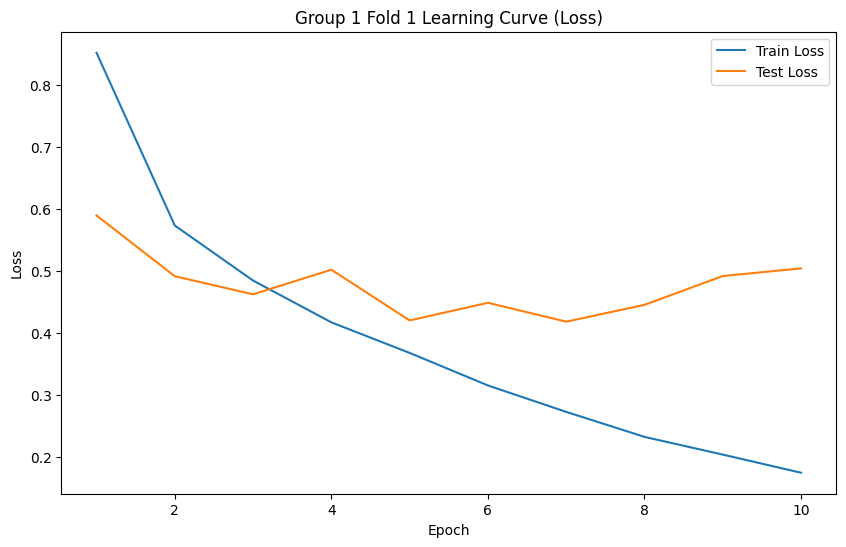

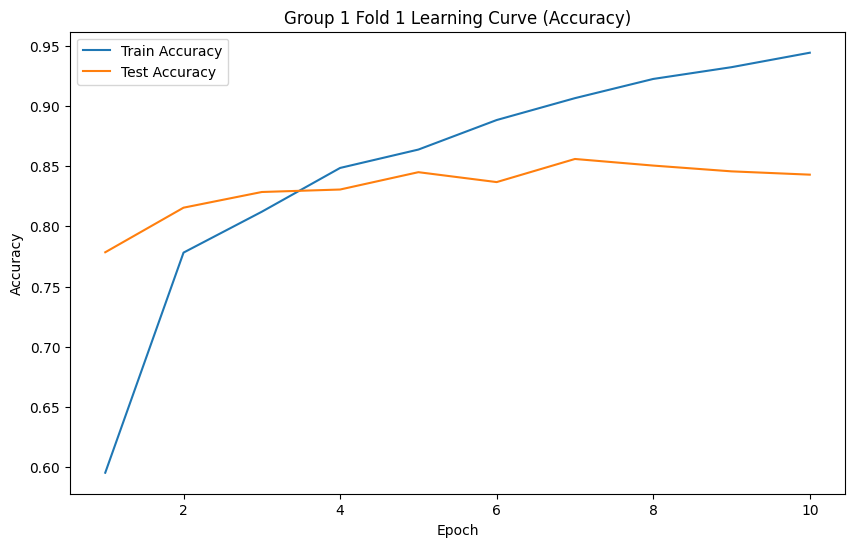

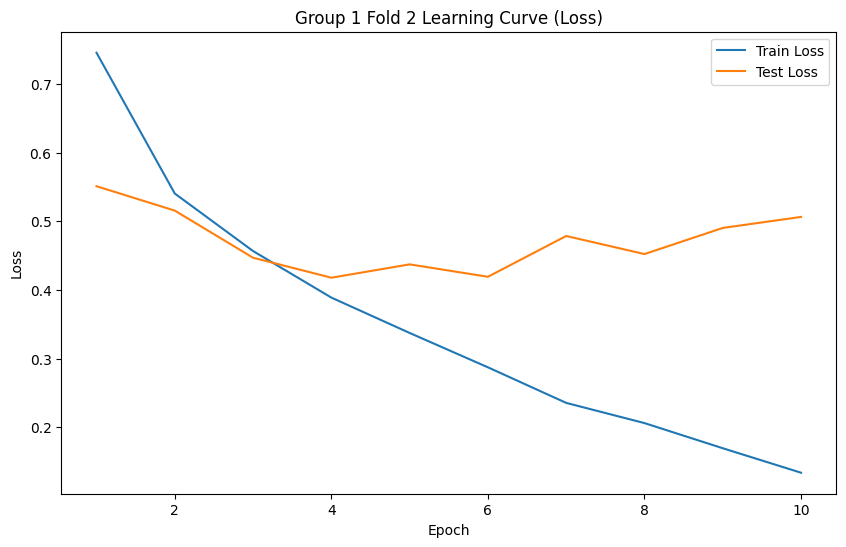

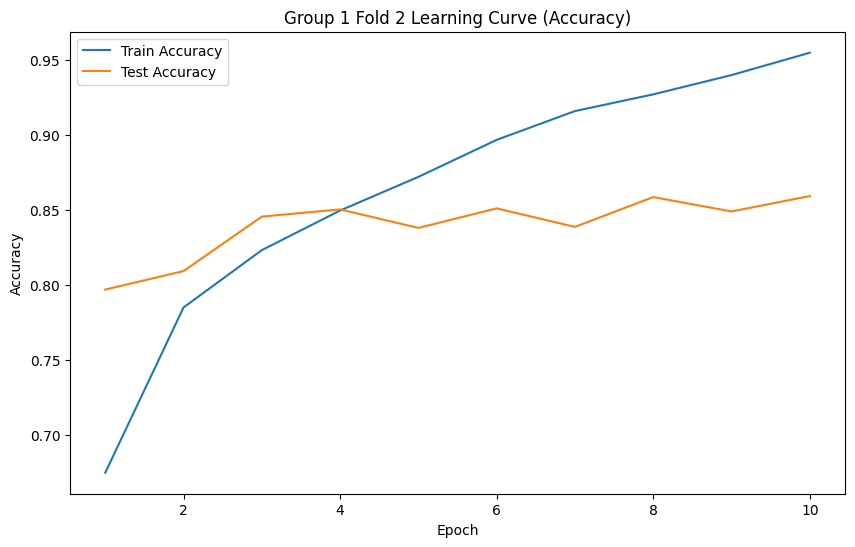

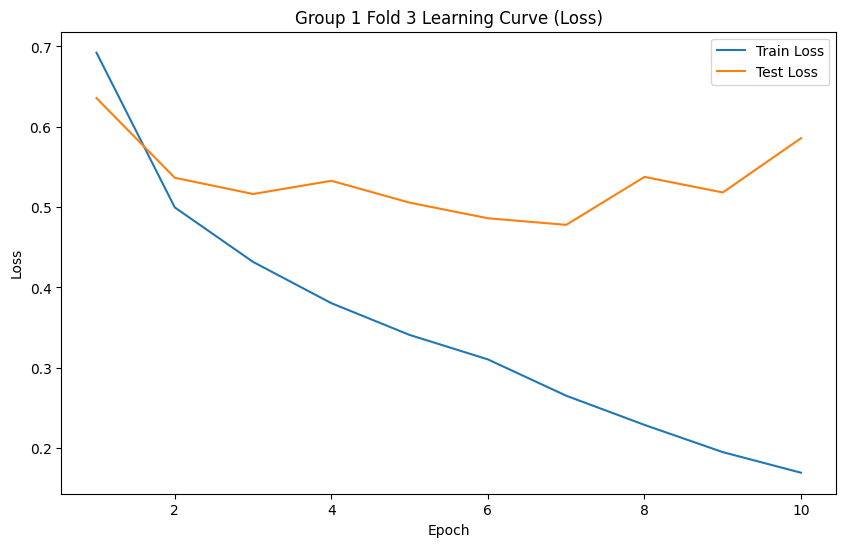

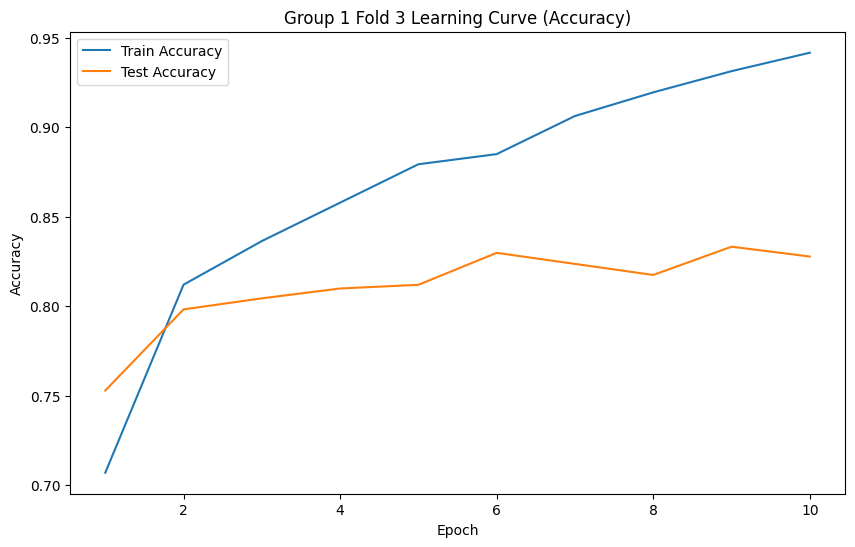

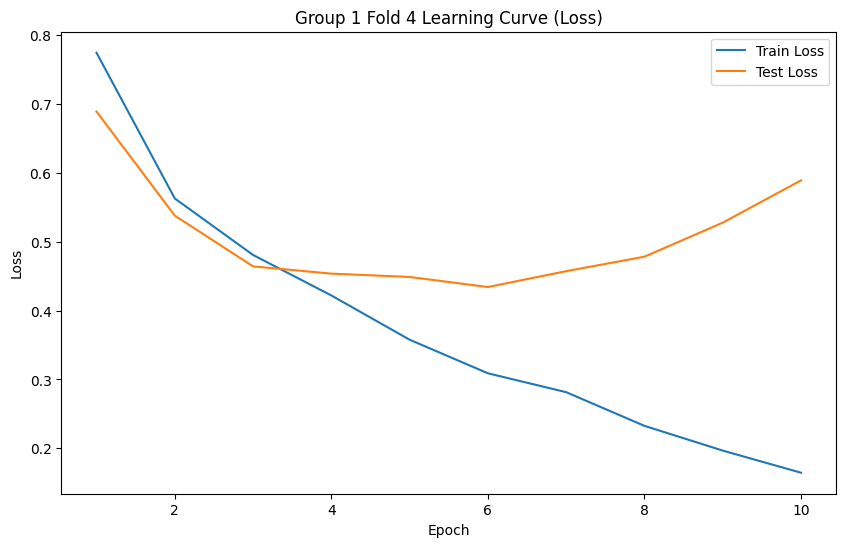

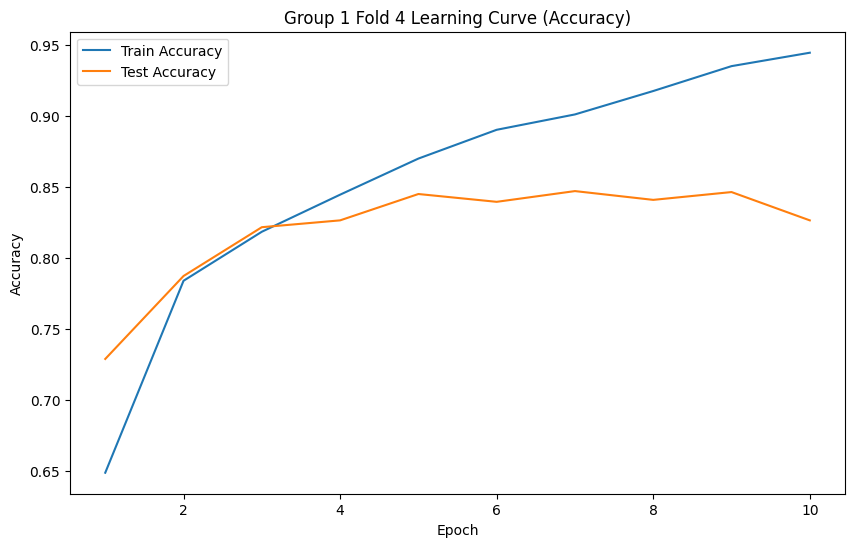

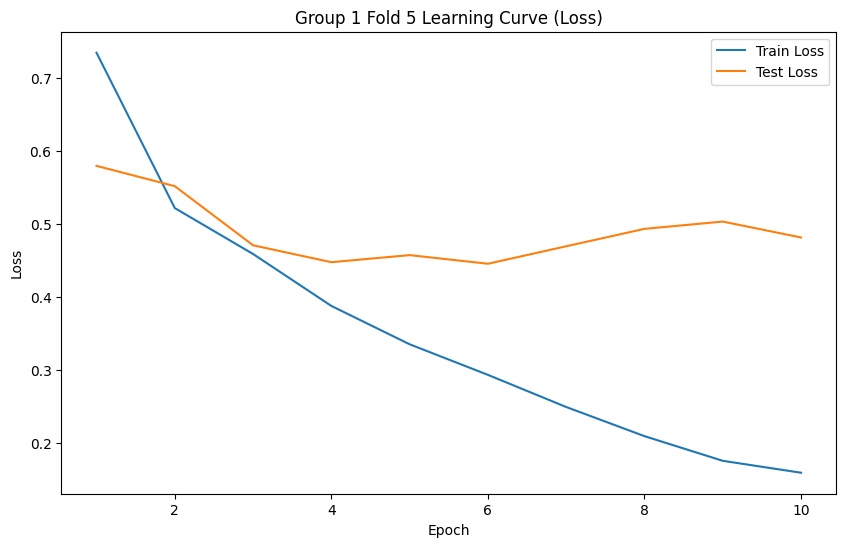

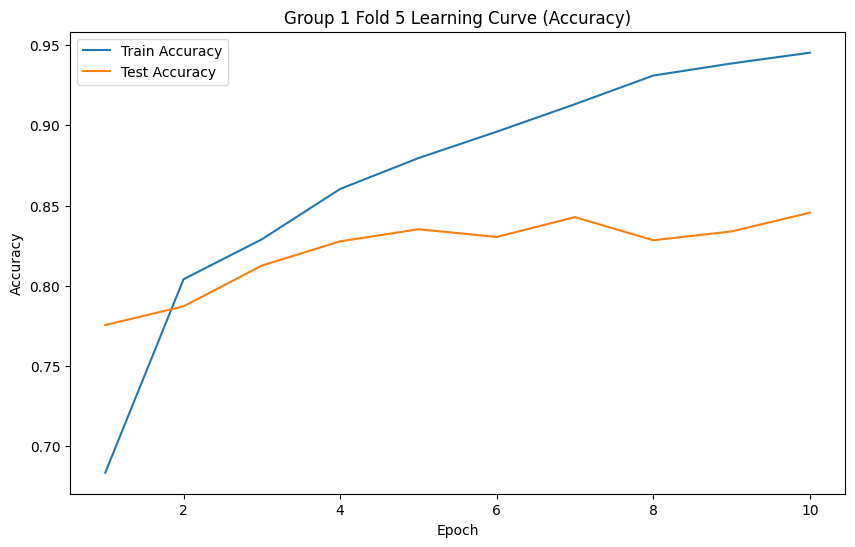

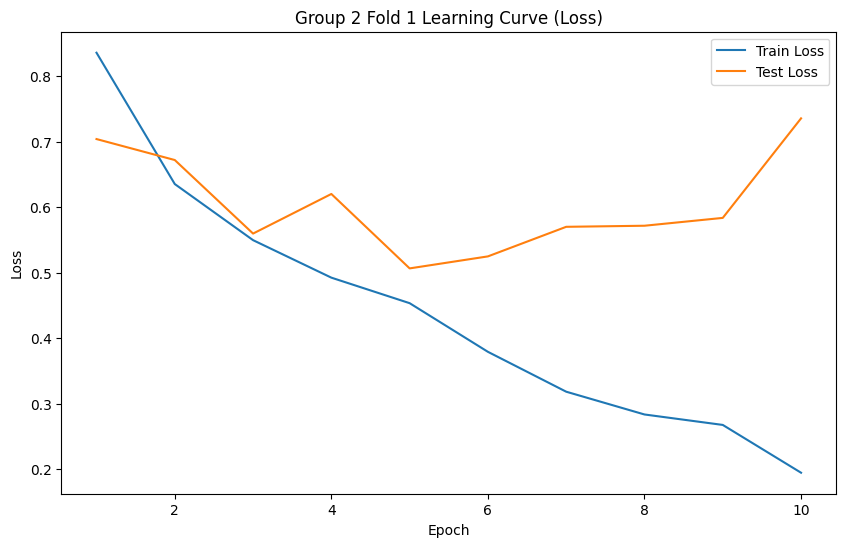

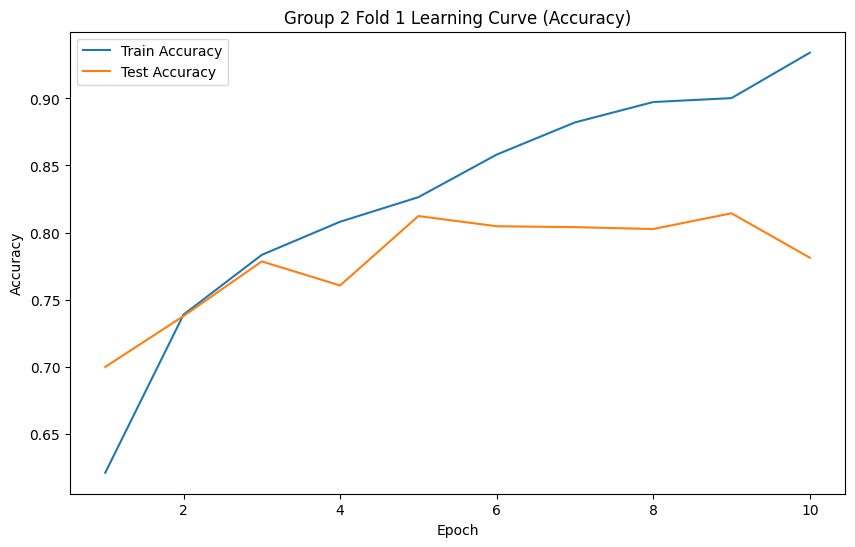

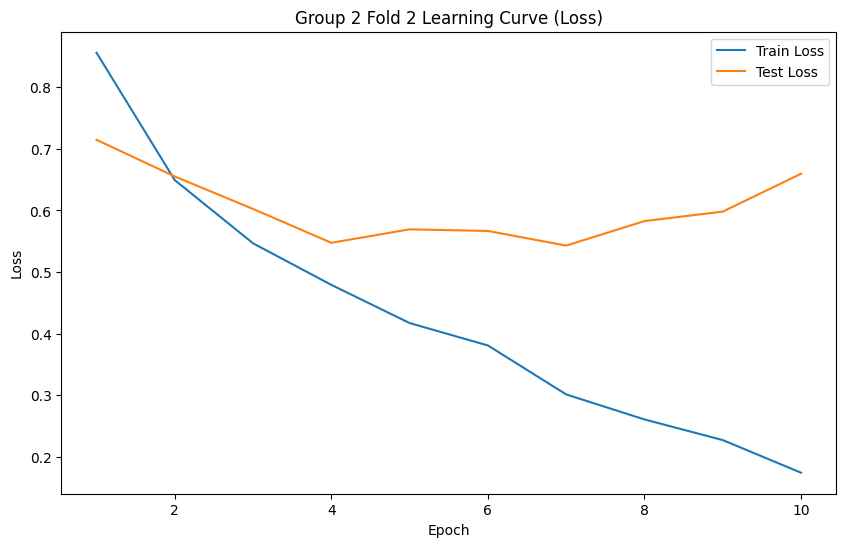

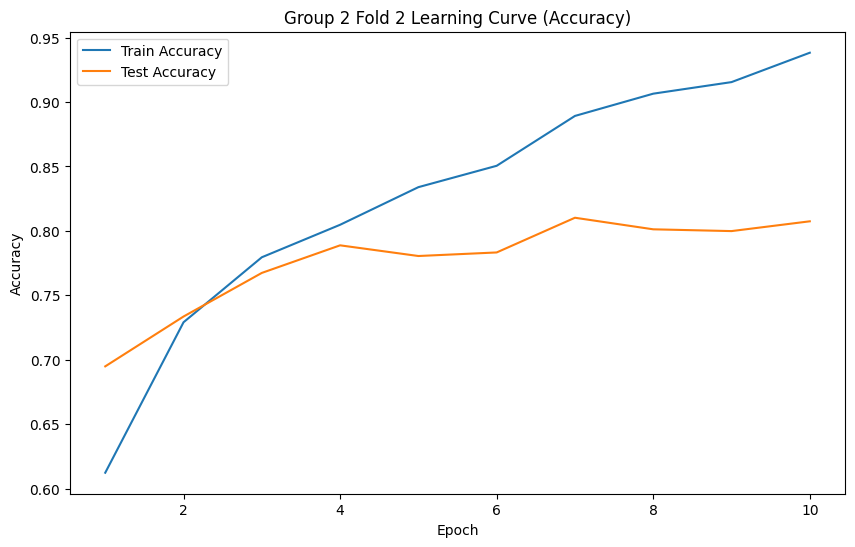

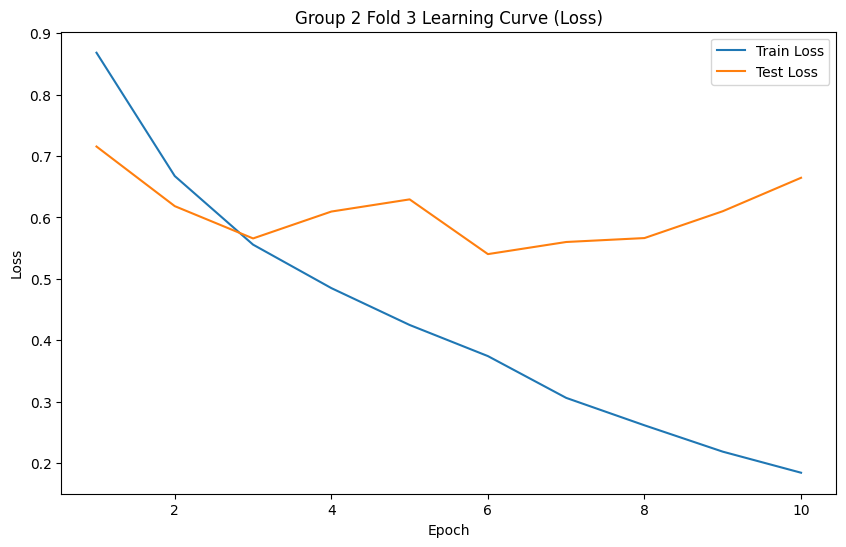

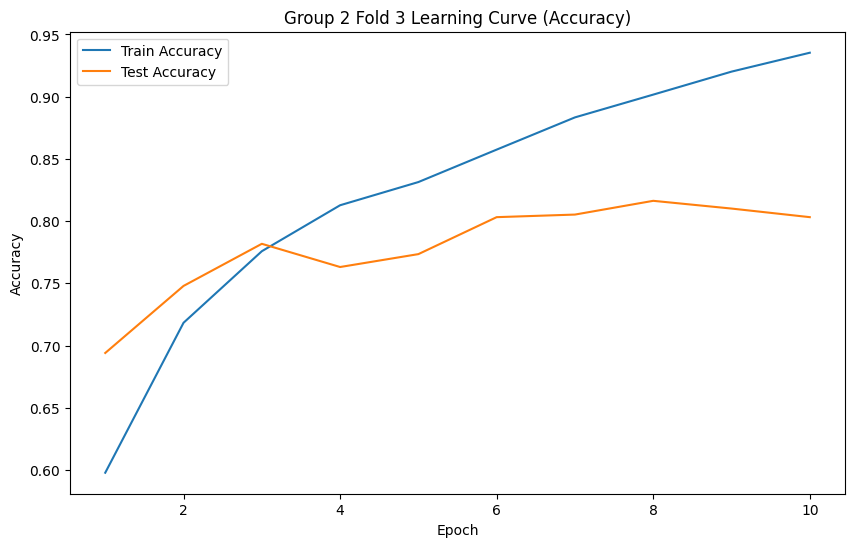

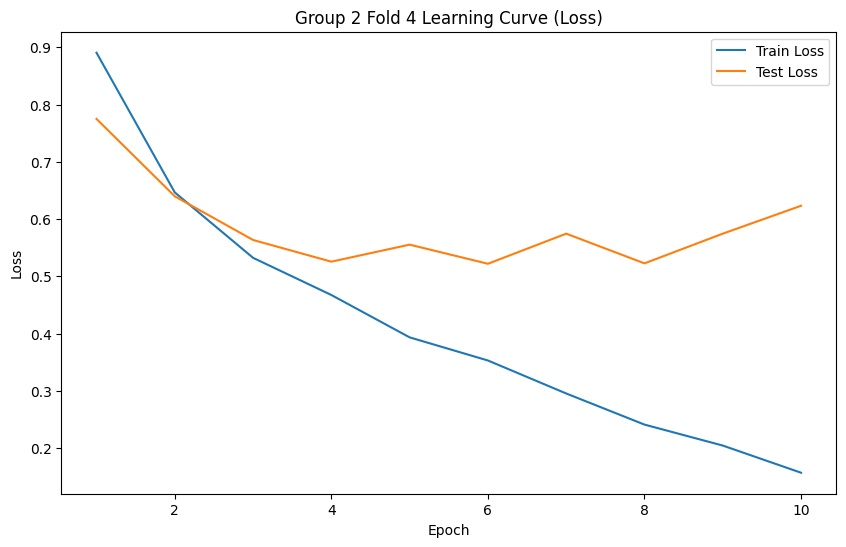

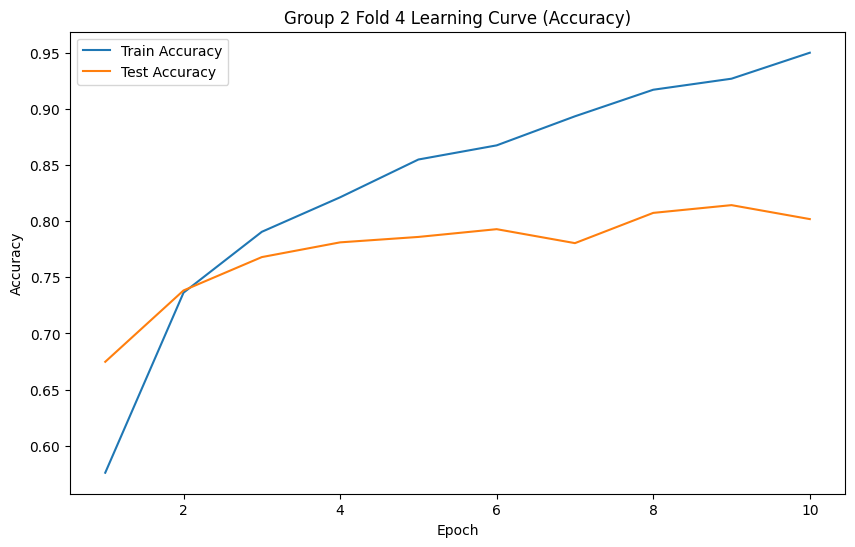

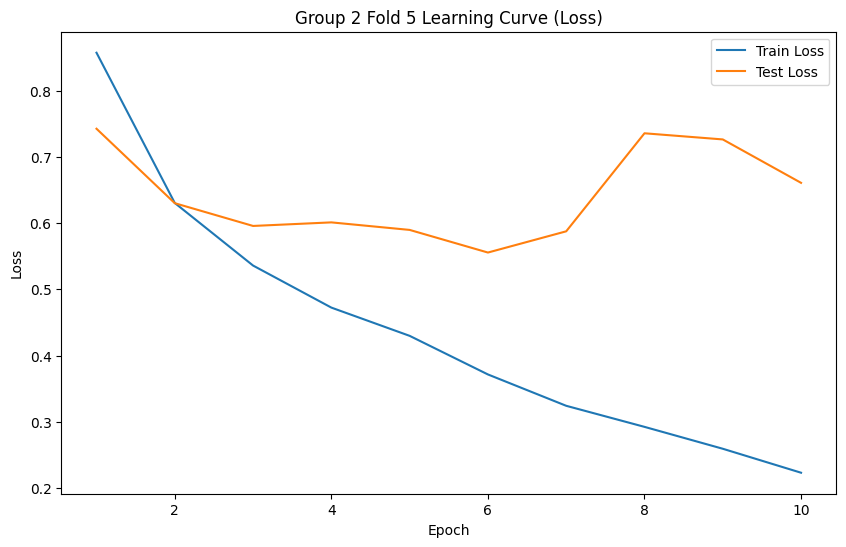

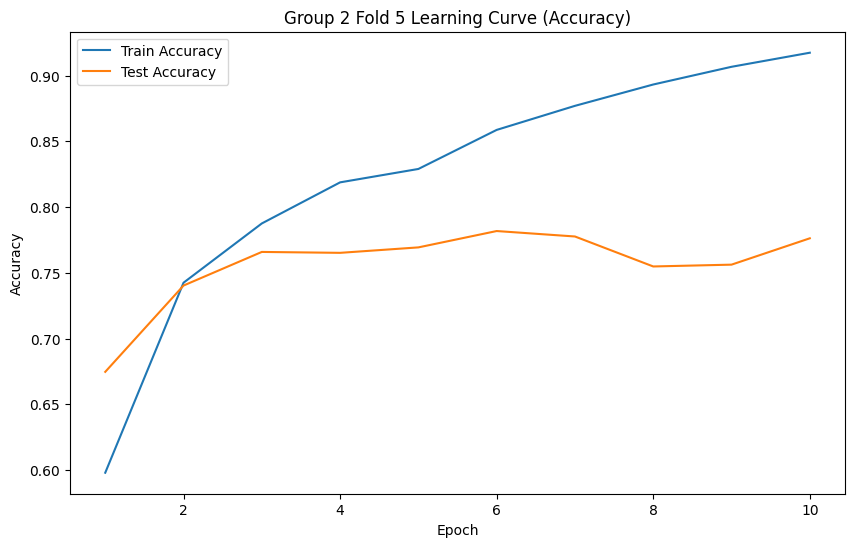

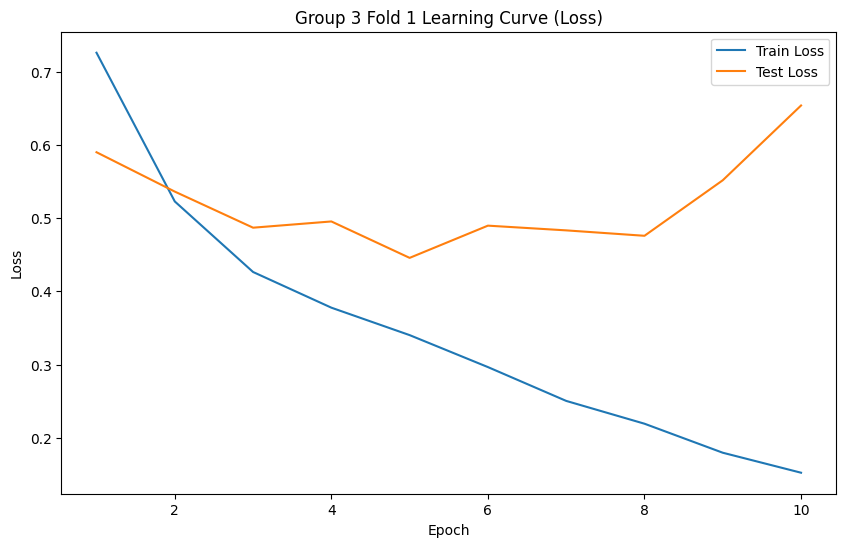

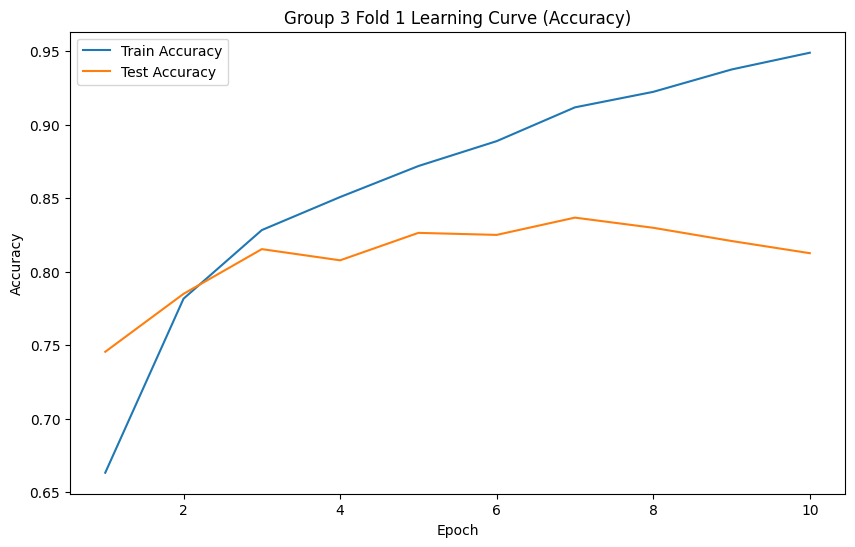

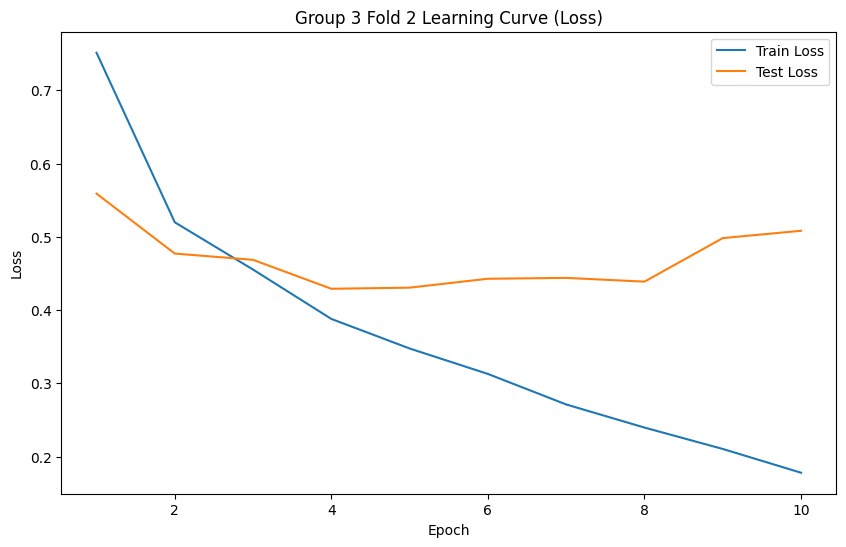

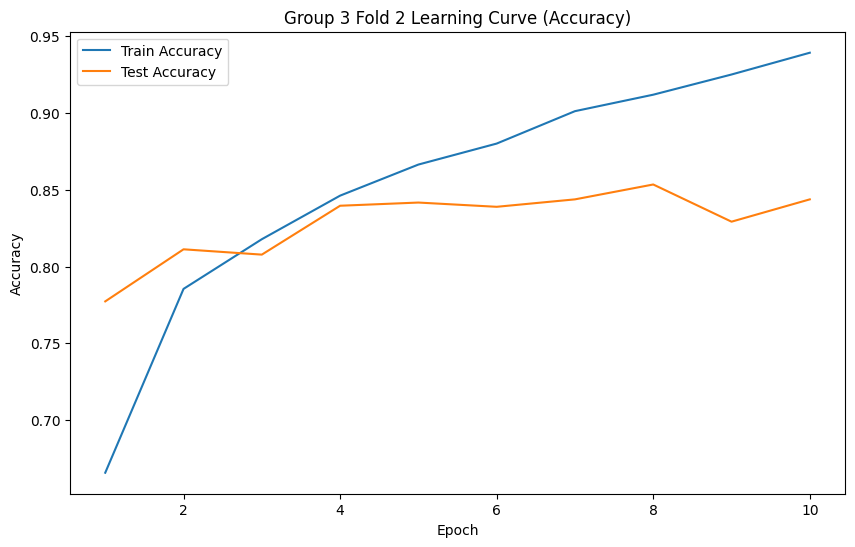

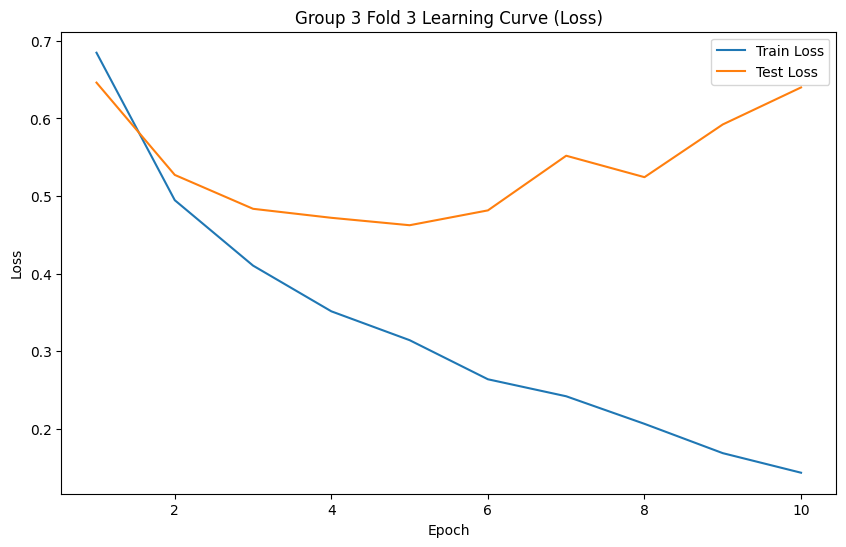

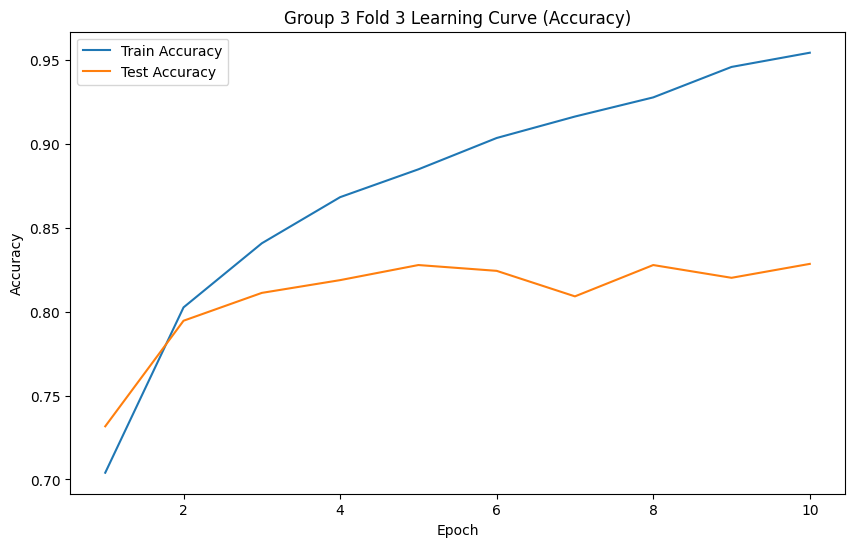

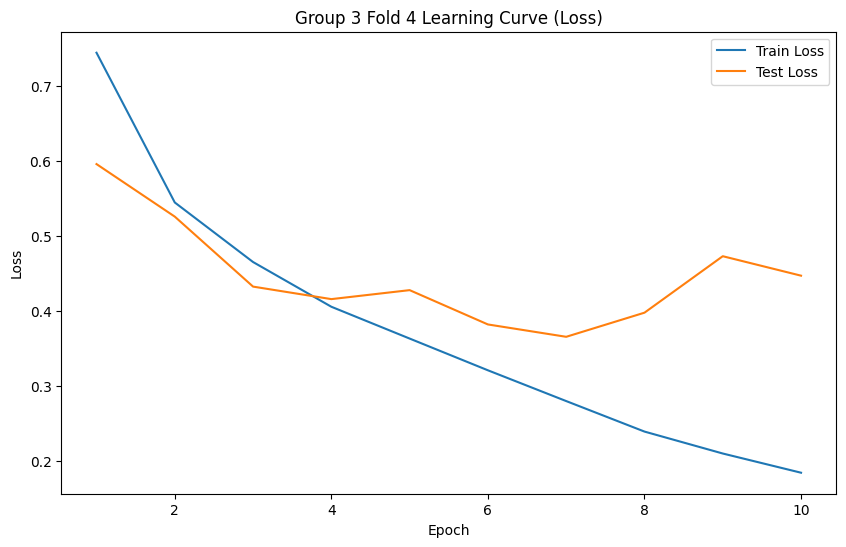

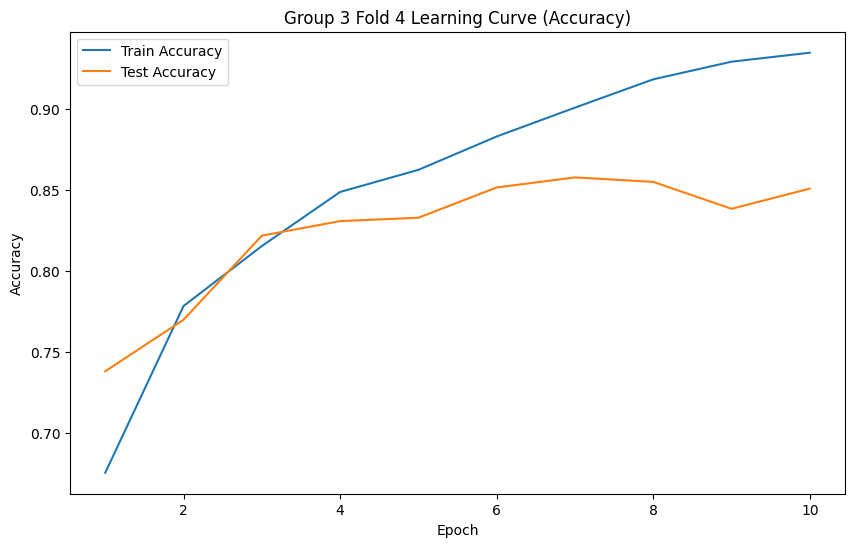

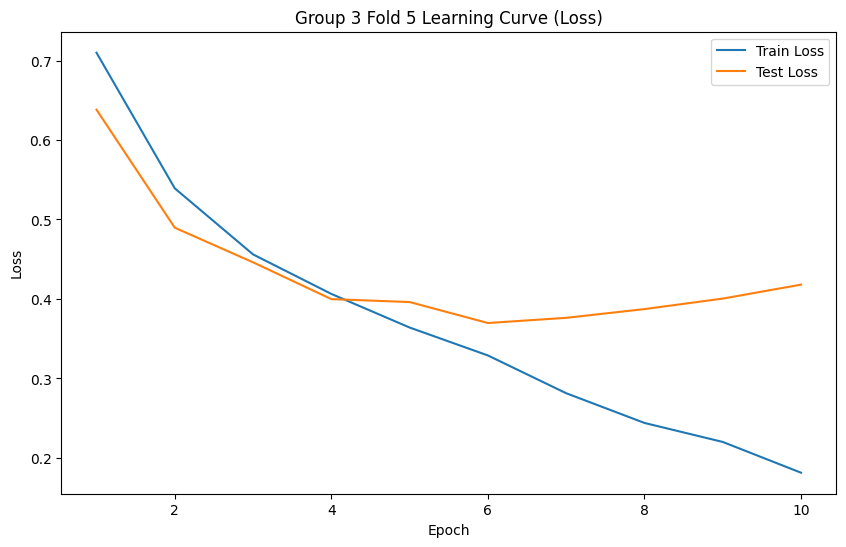

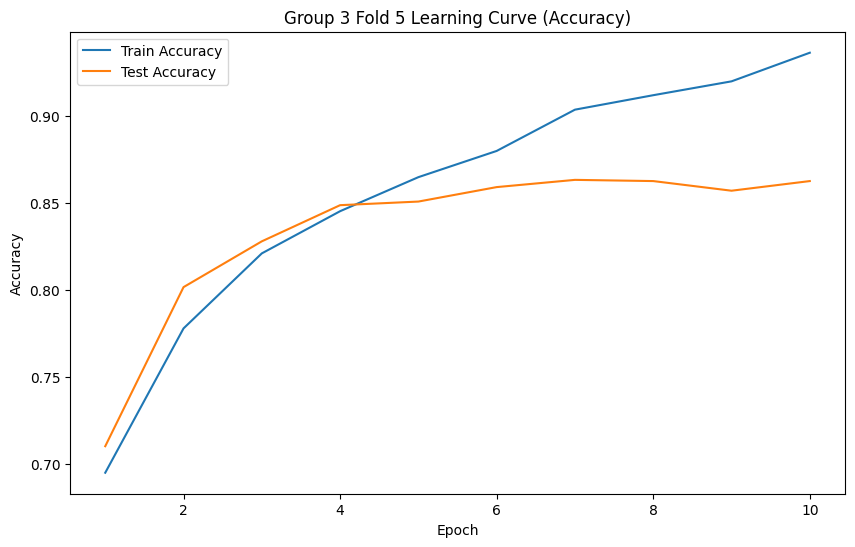

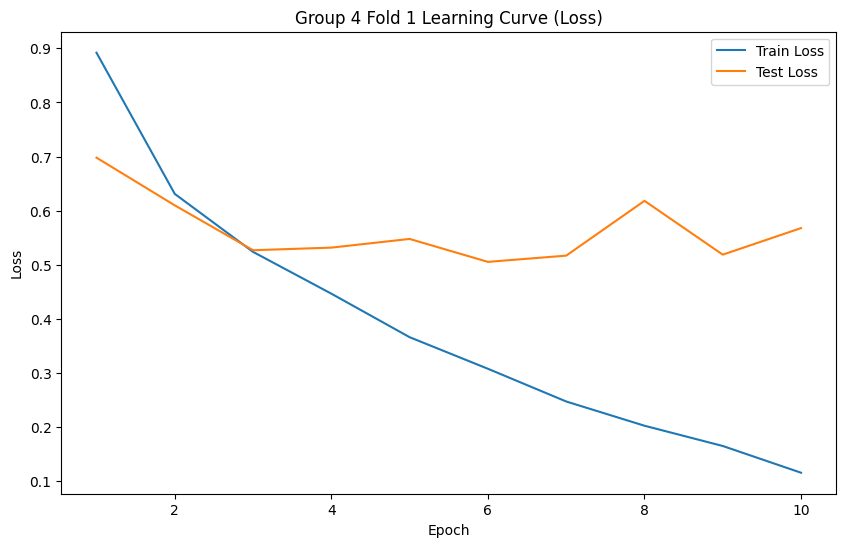

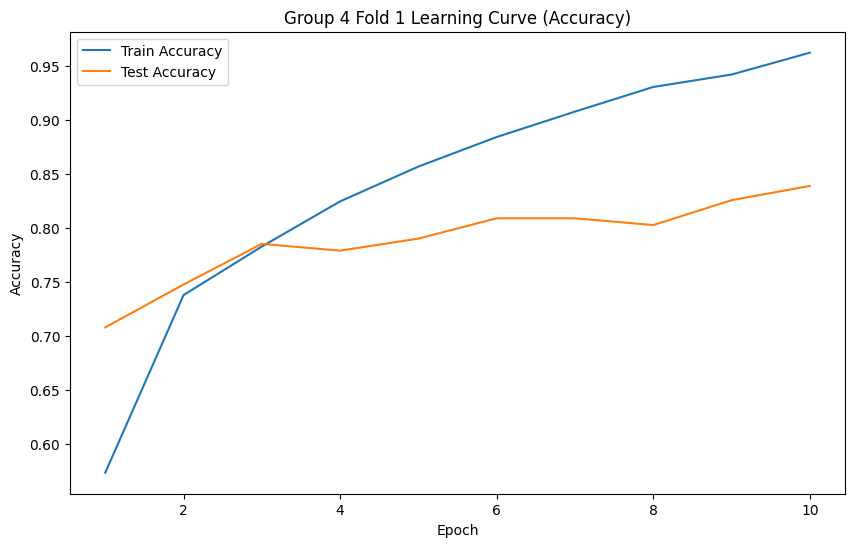

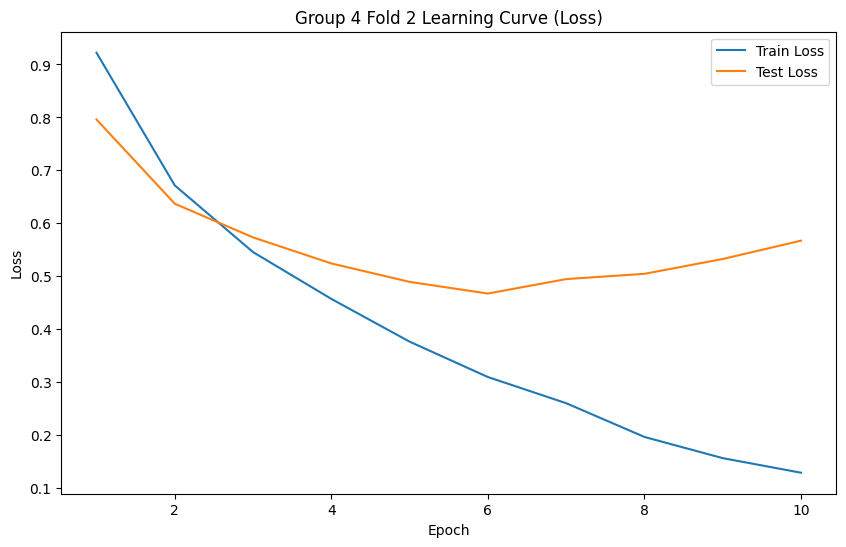

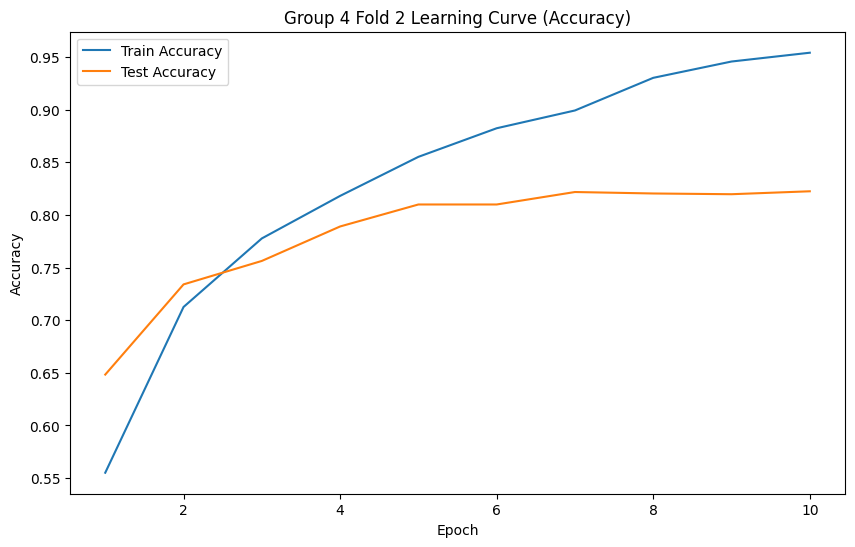

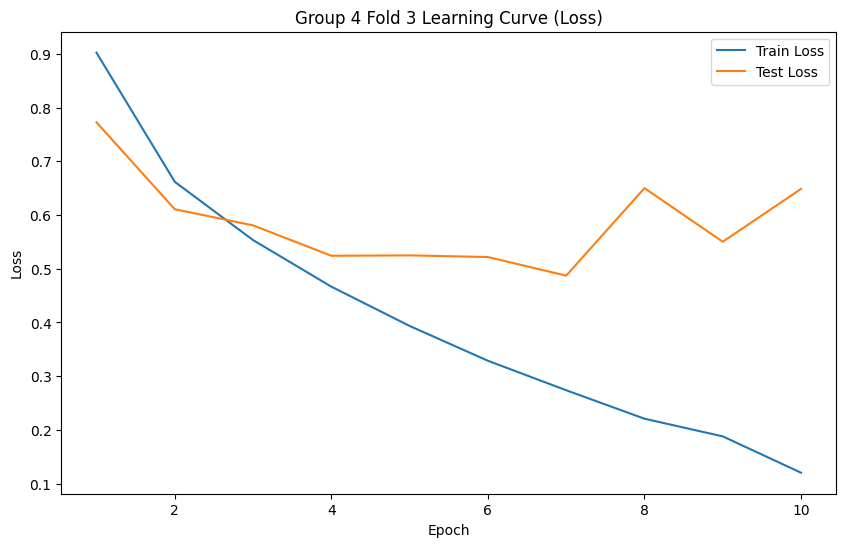

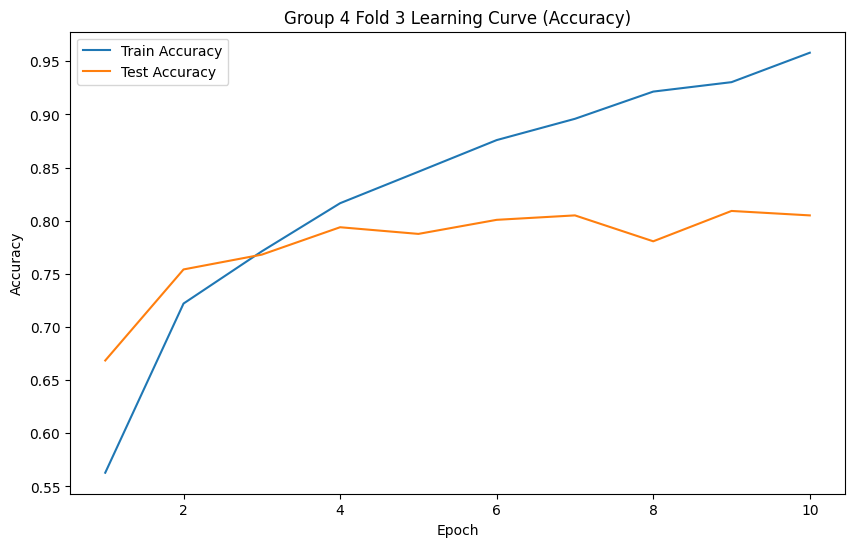

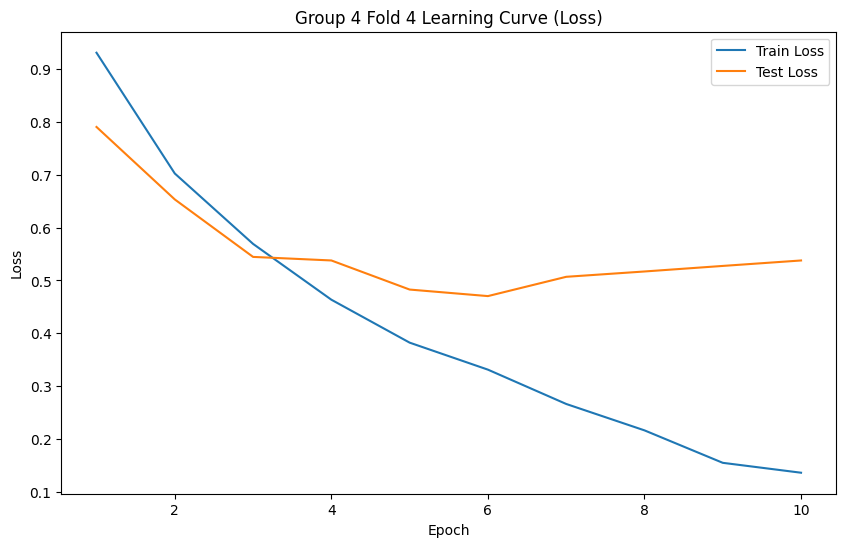

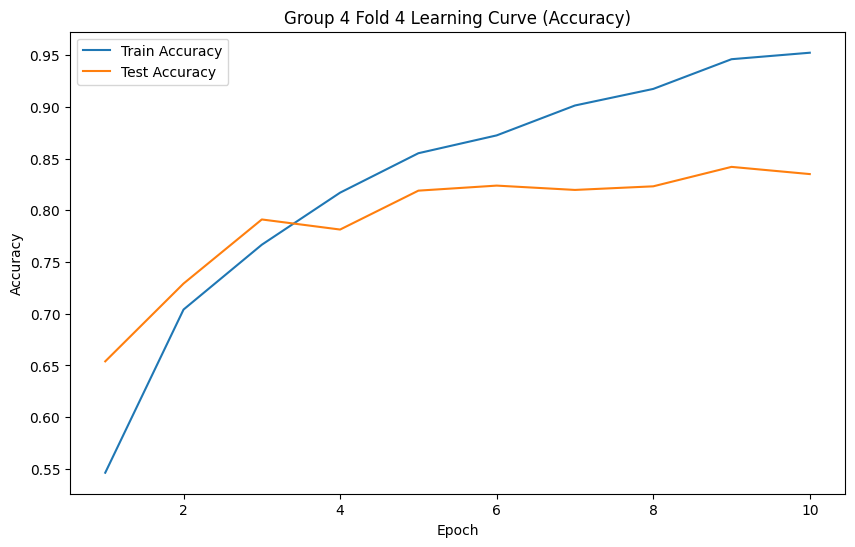

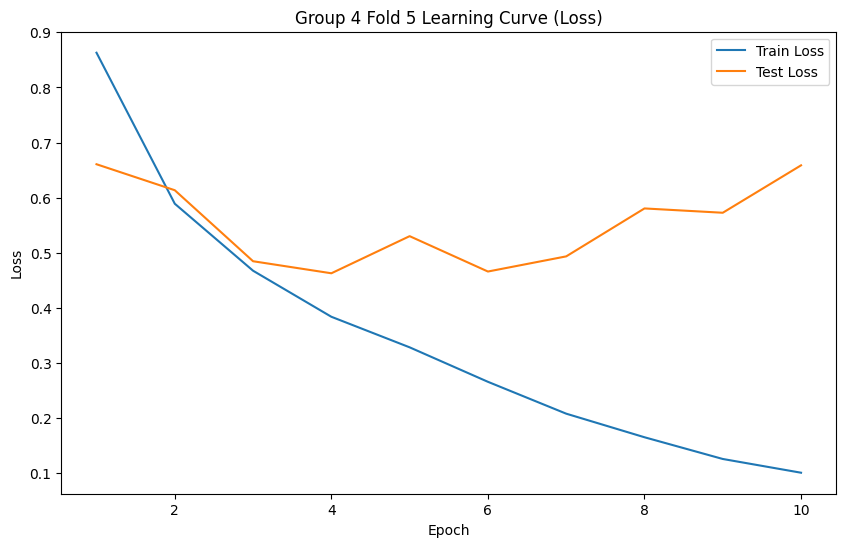

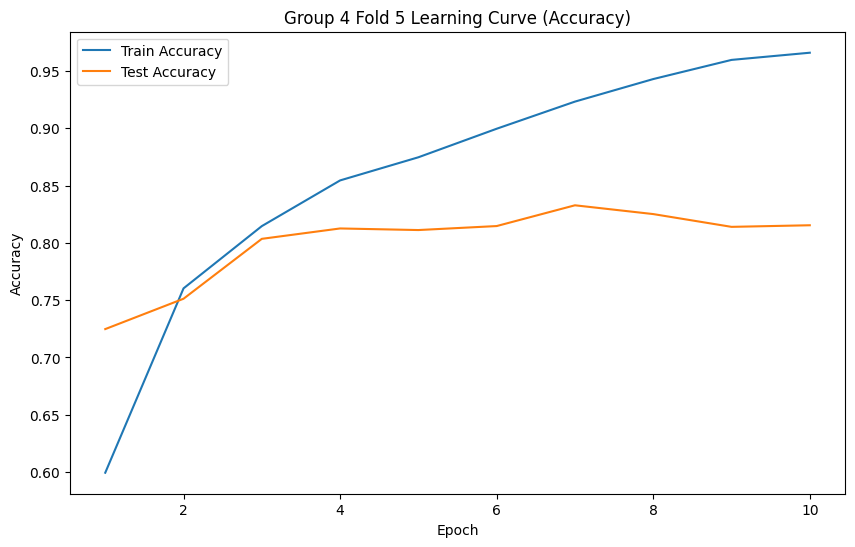

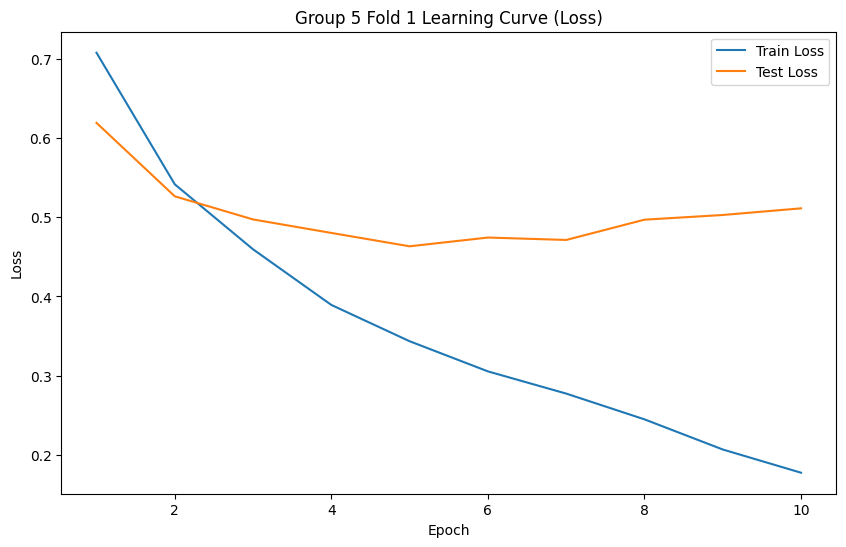

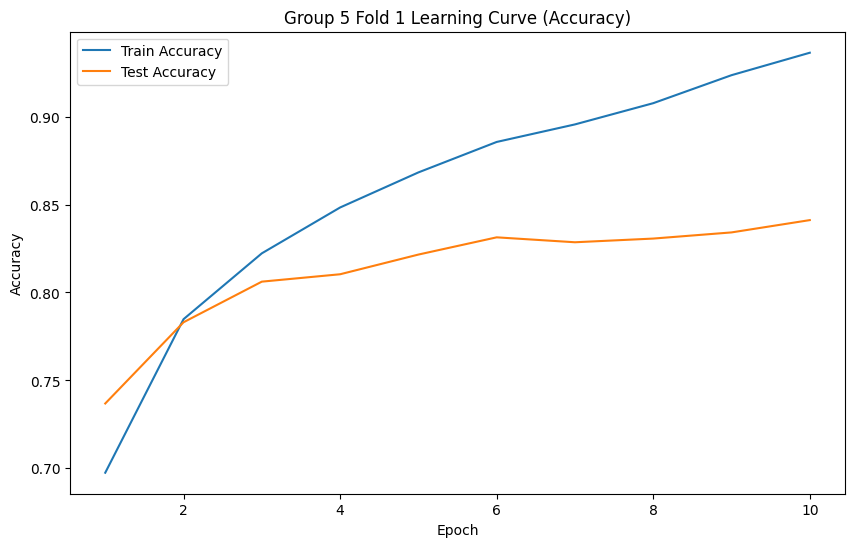

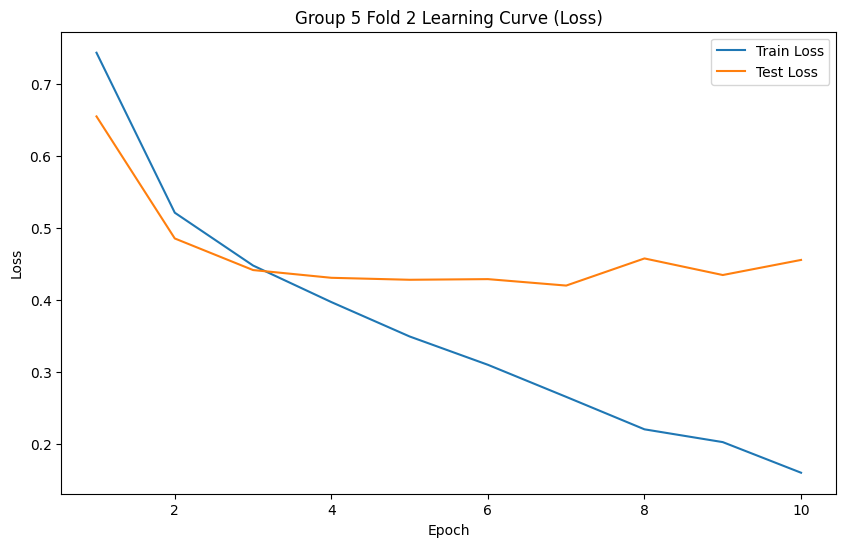

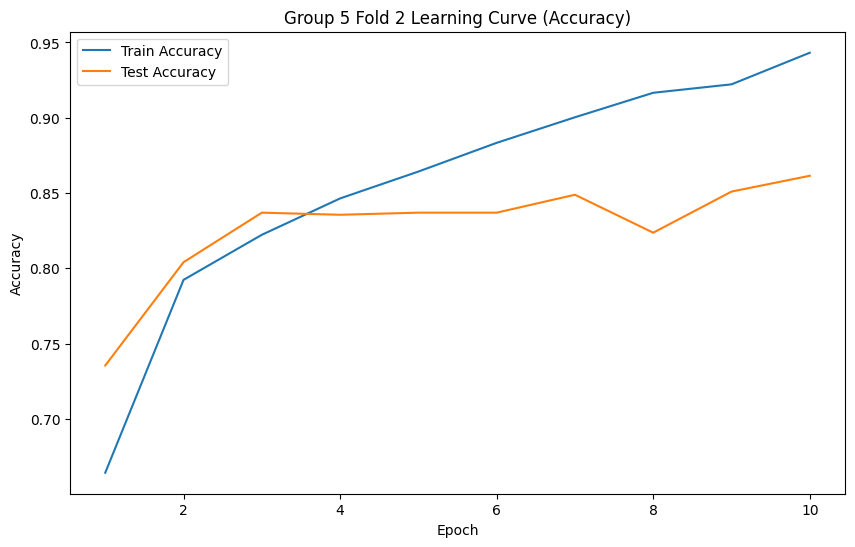

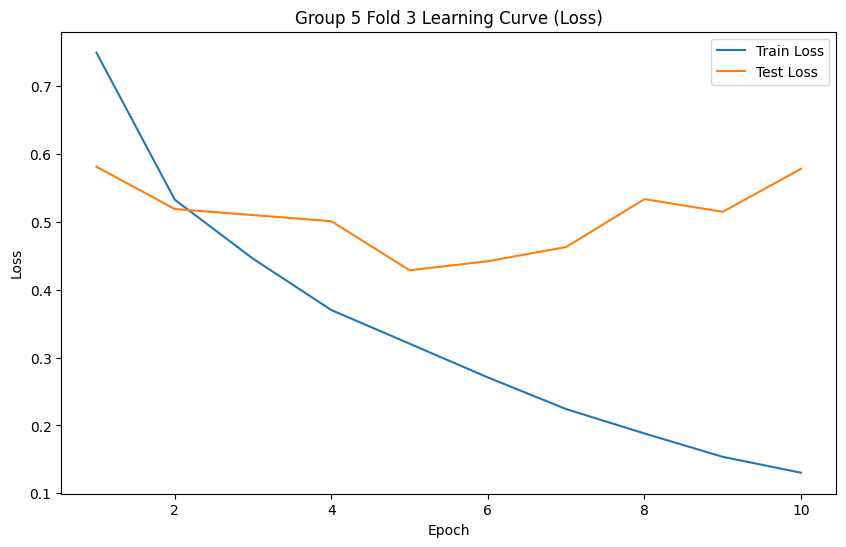

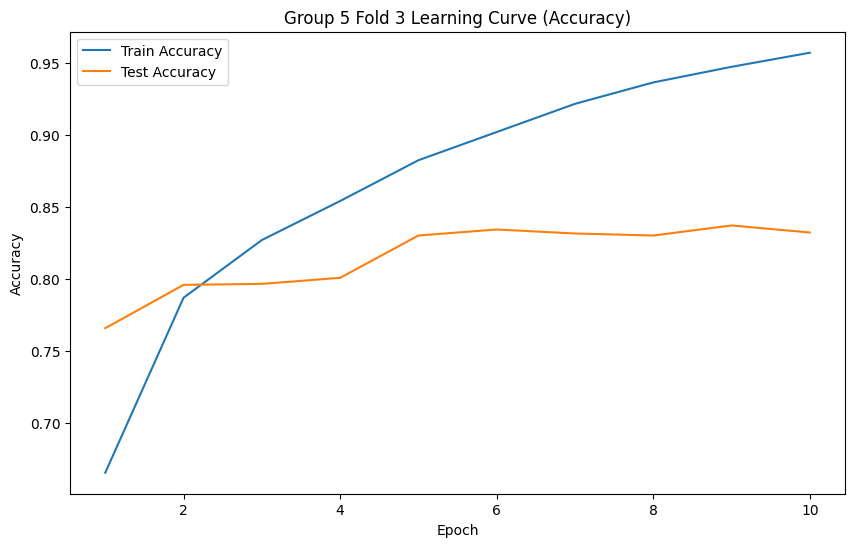

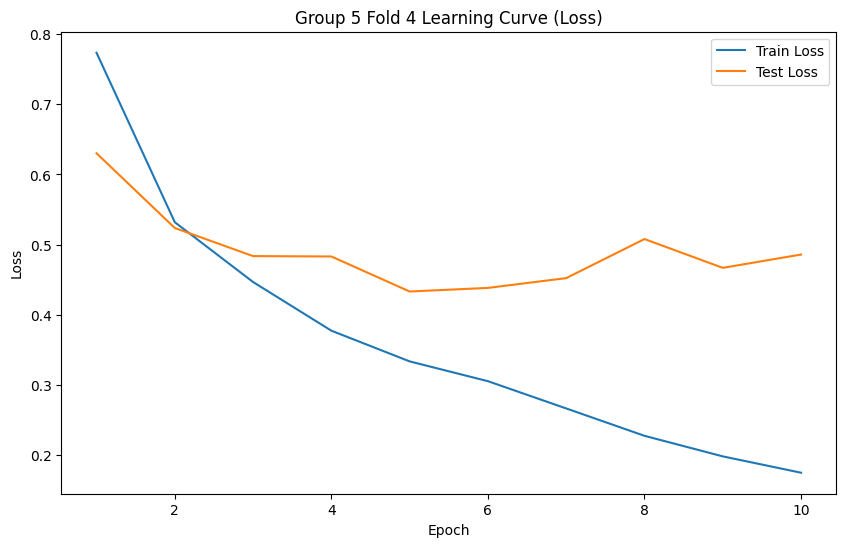

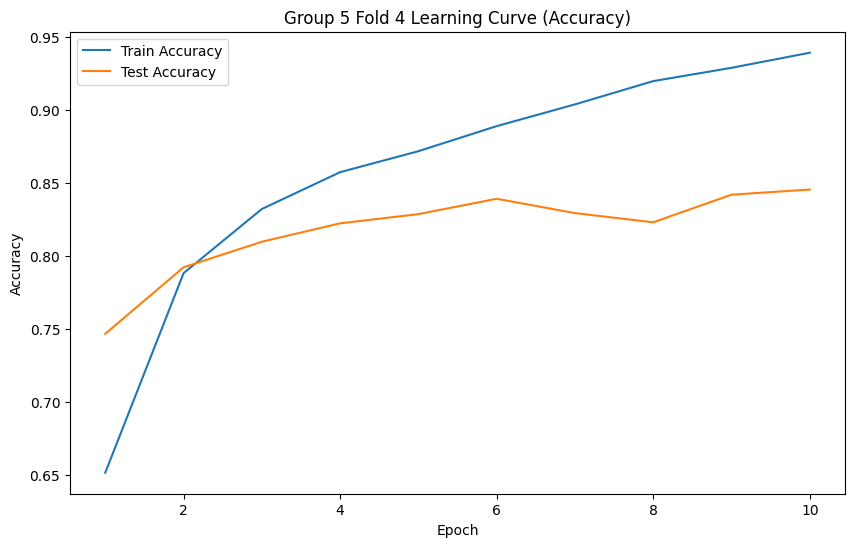

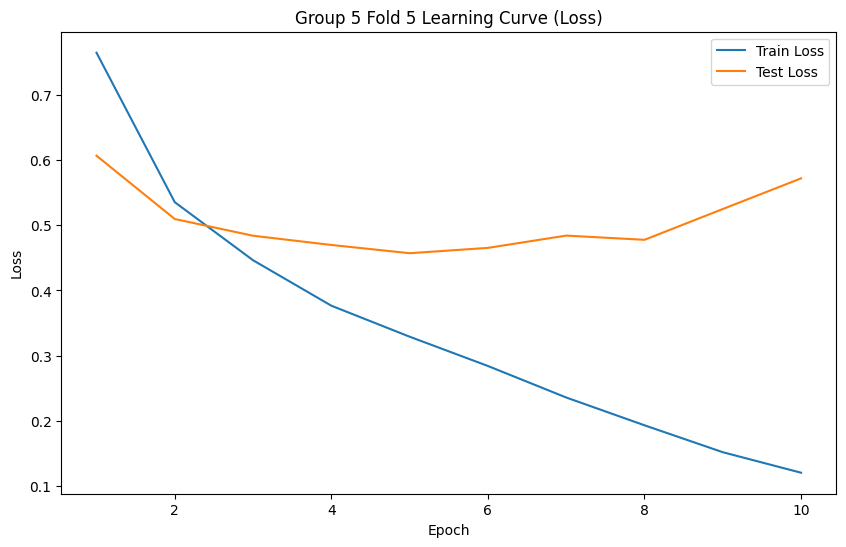

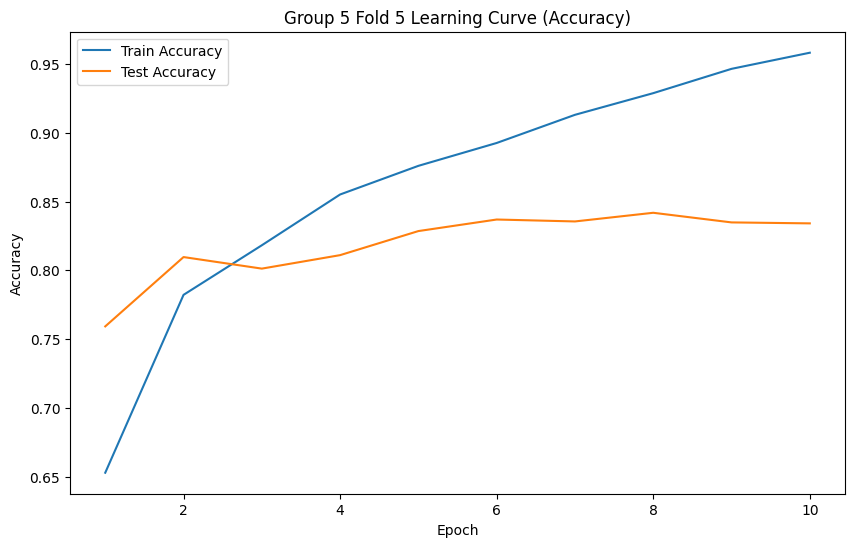

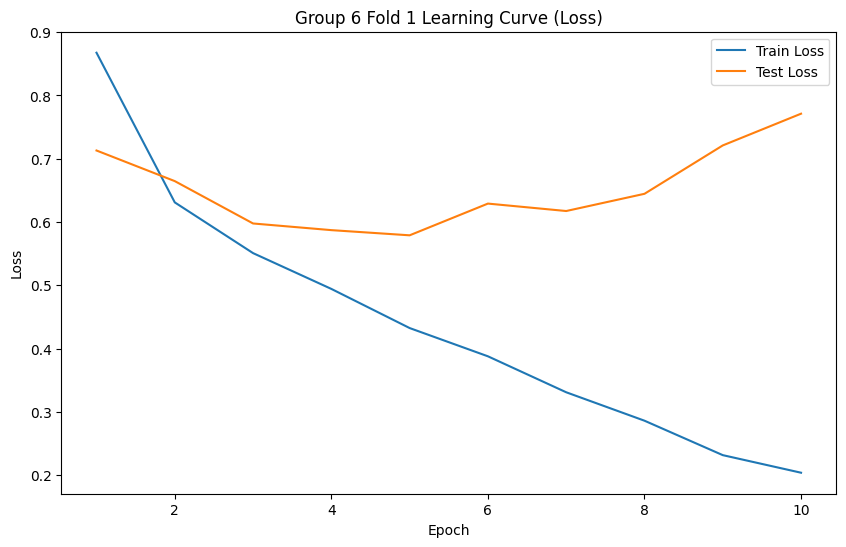

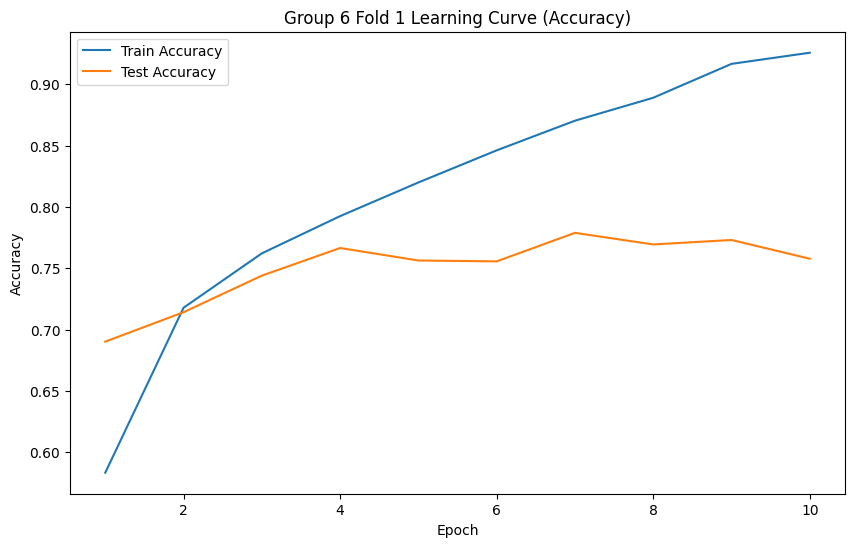

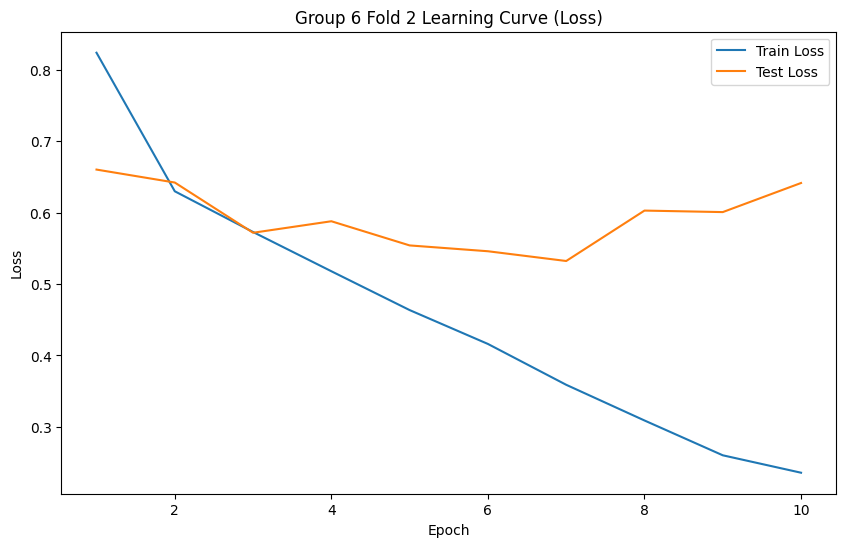

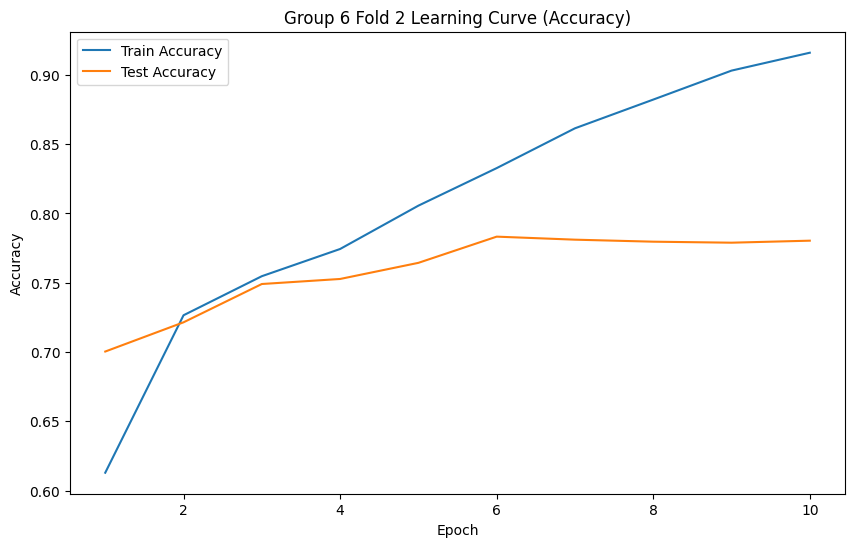

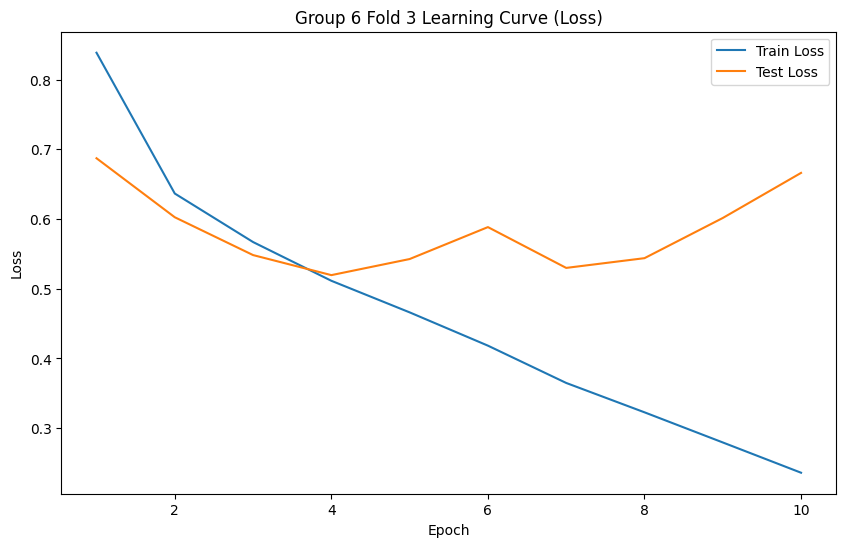

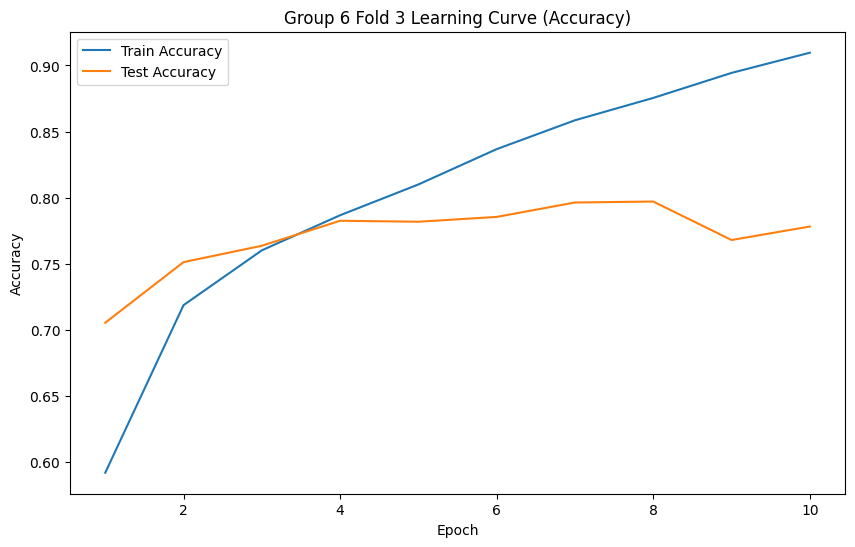

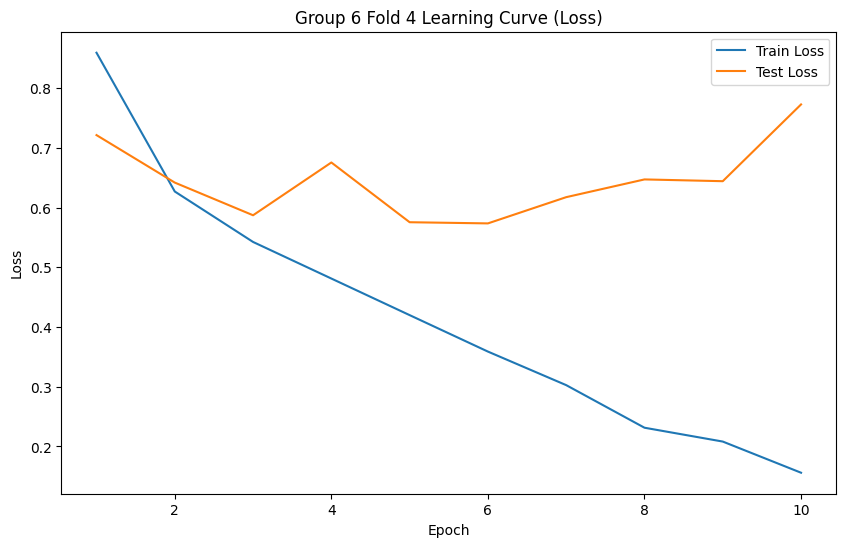

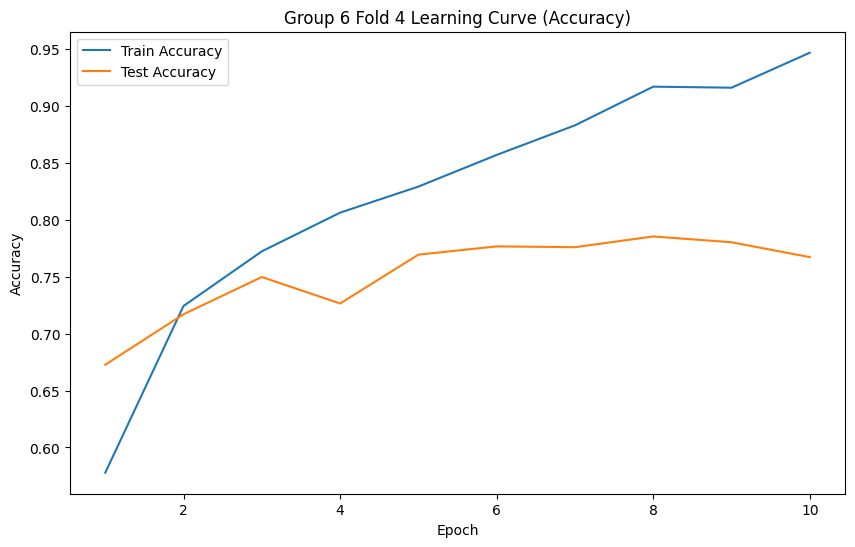

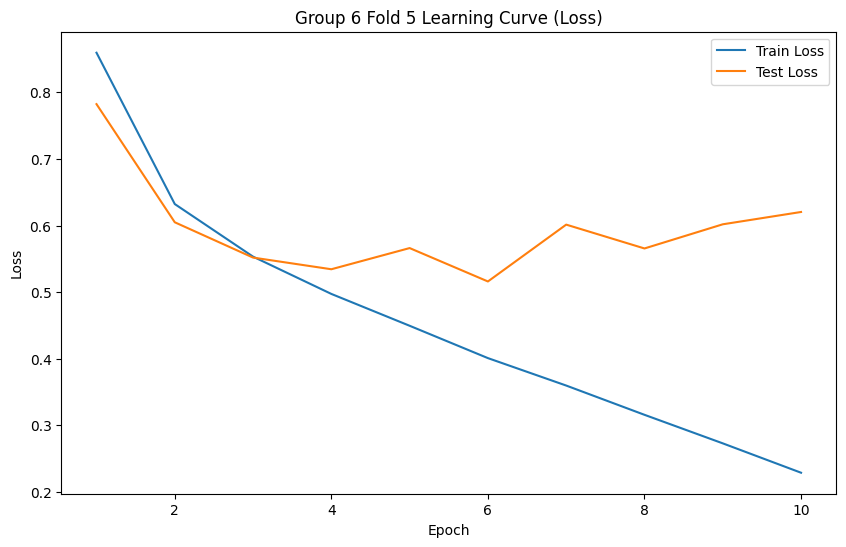

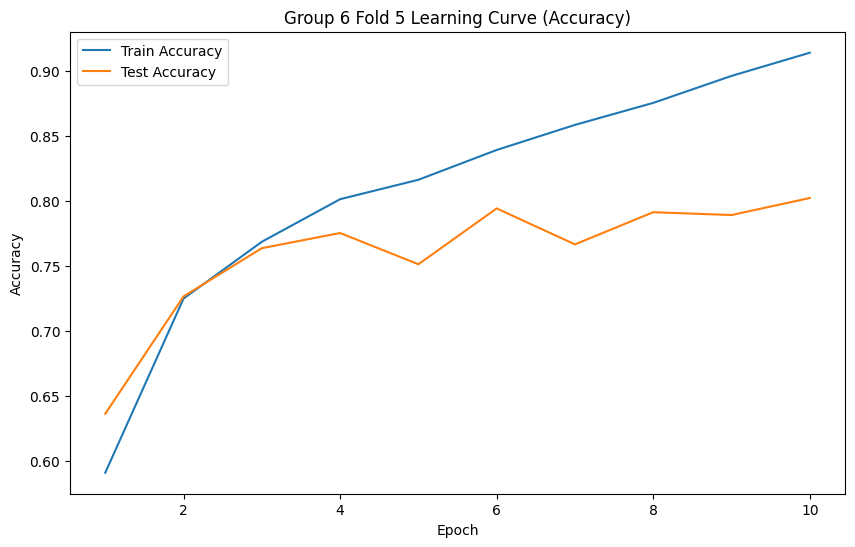

In [15]:
for curve in all_learning_curves:
    group_idx, fold_idx = curve["Group"], curve["Fold"]
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, EPOCHS + 1), curve["train_losses"], label="Train Loss")
    plt.plot(range(1, EPOCHS + 1), curve["test_losses"], label="Test Loss")
    plt.title(f"Group {group_idx} Fold {fold_idx} Learning Curve (Loss)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, EPOCHS + 1), curve["train_accuracies"], label="Train Accuracy")
    plt.plot(range(1, EPOCHS + 1), curve["test_accuracies"], label="Test Accuracy")
    plt.title(f"Group {group_idx} Fold {fold_idx} Learning Curve (Accuracy)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

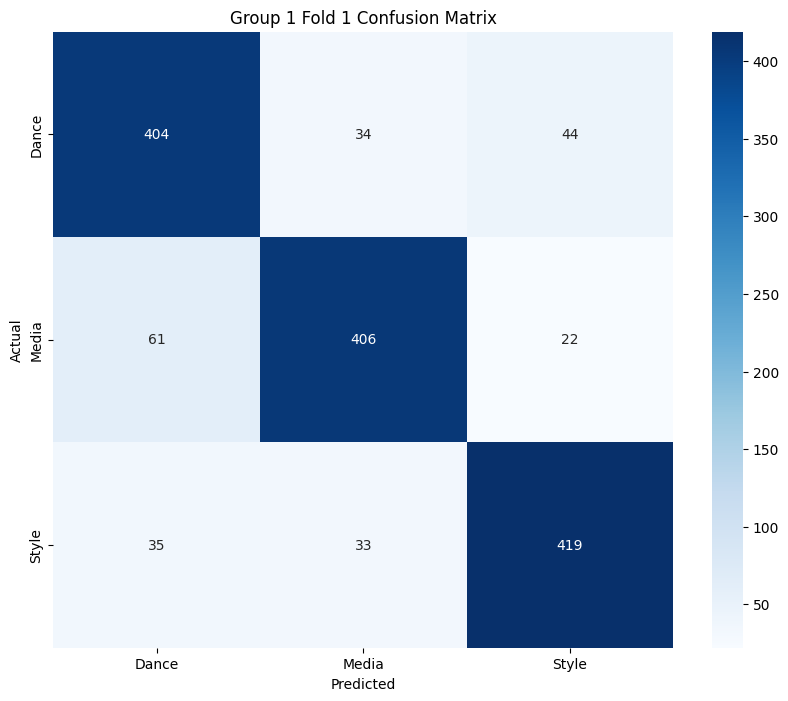

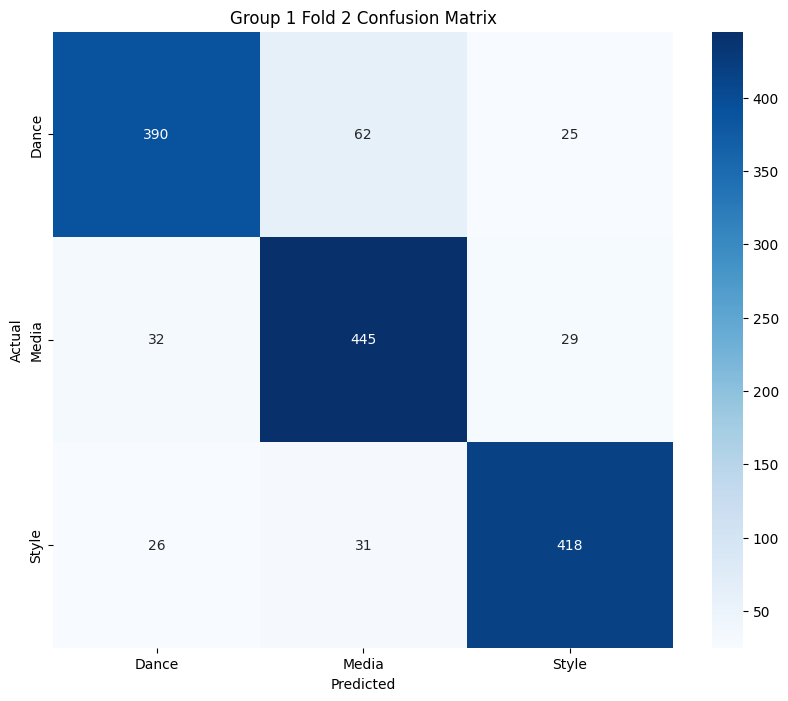

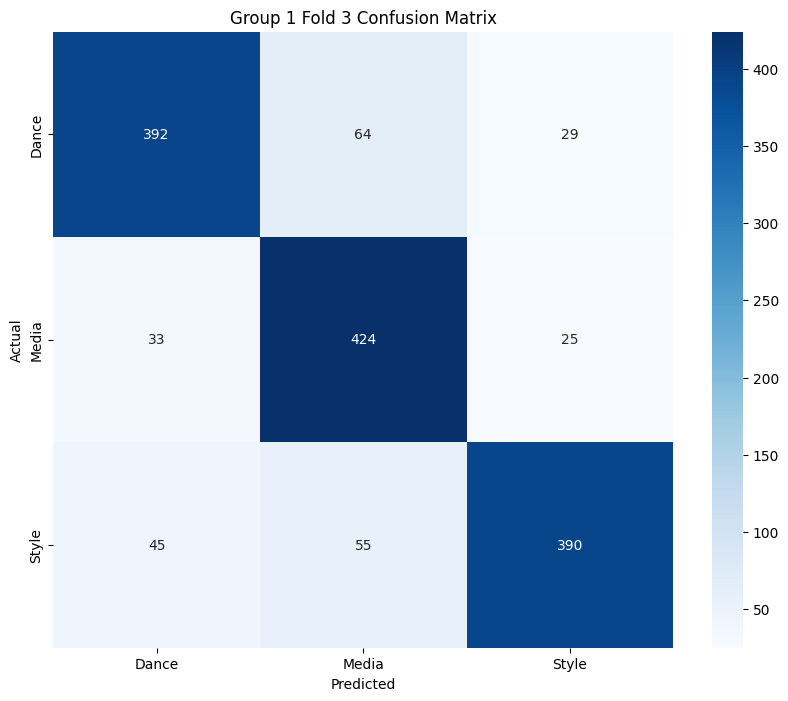

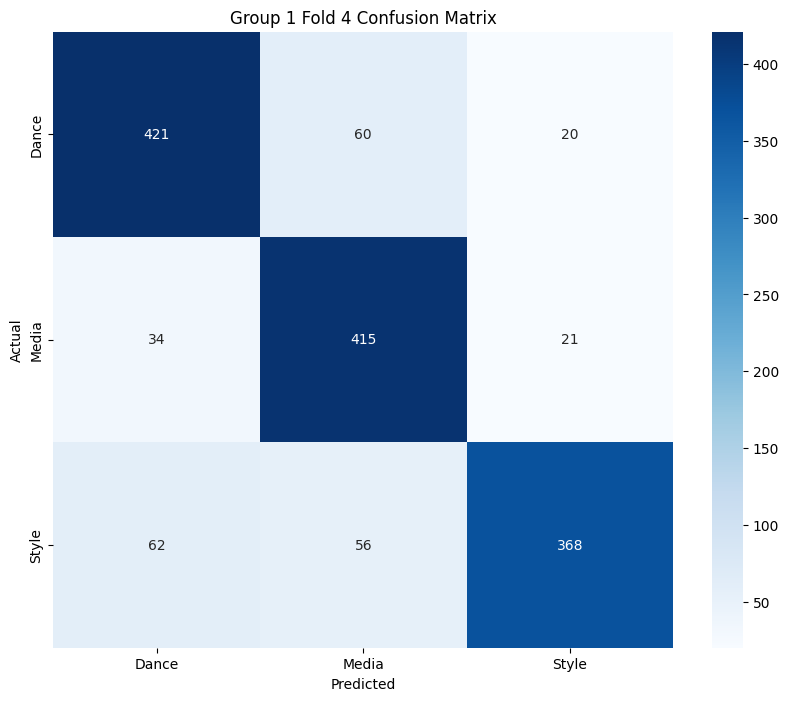

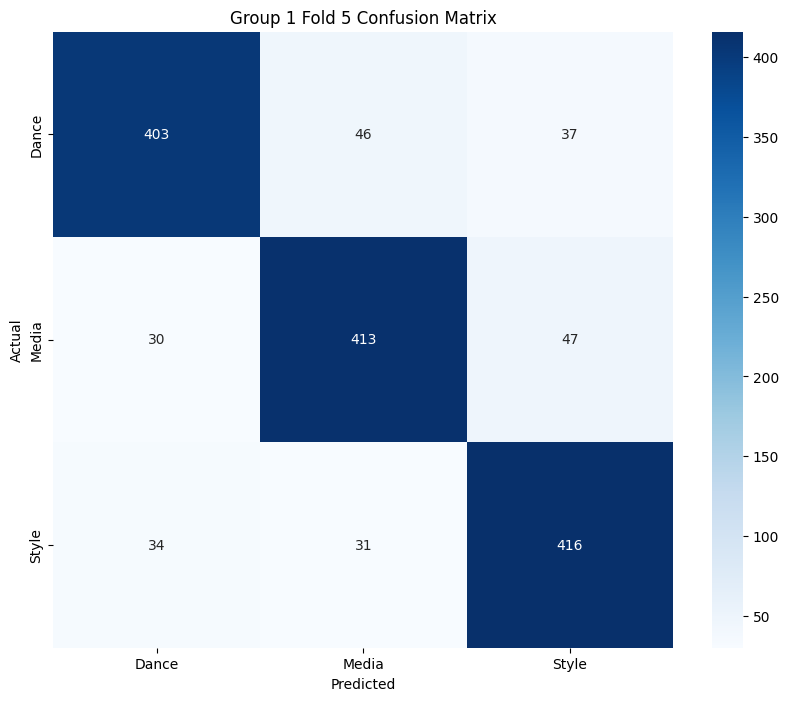

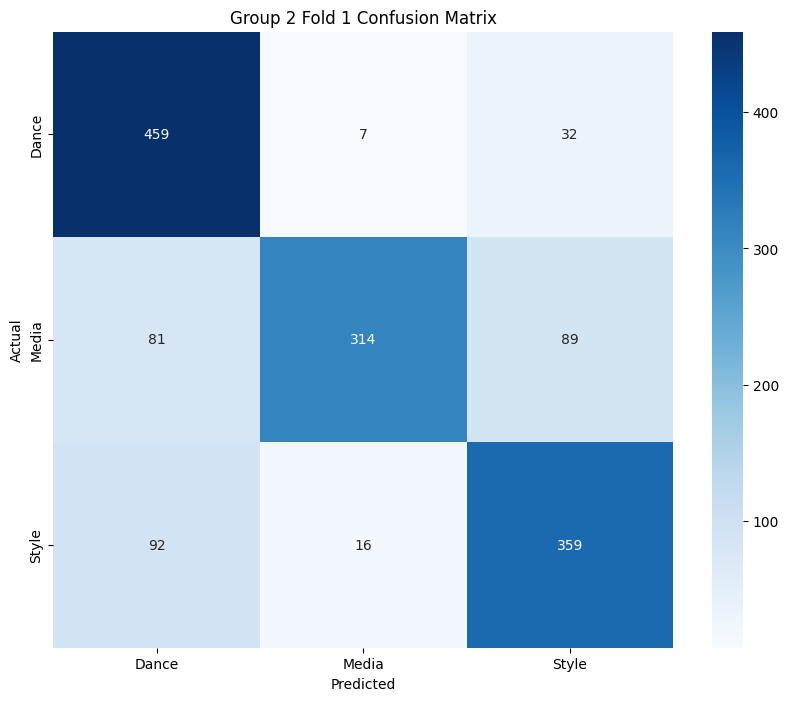

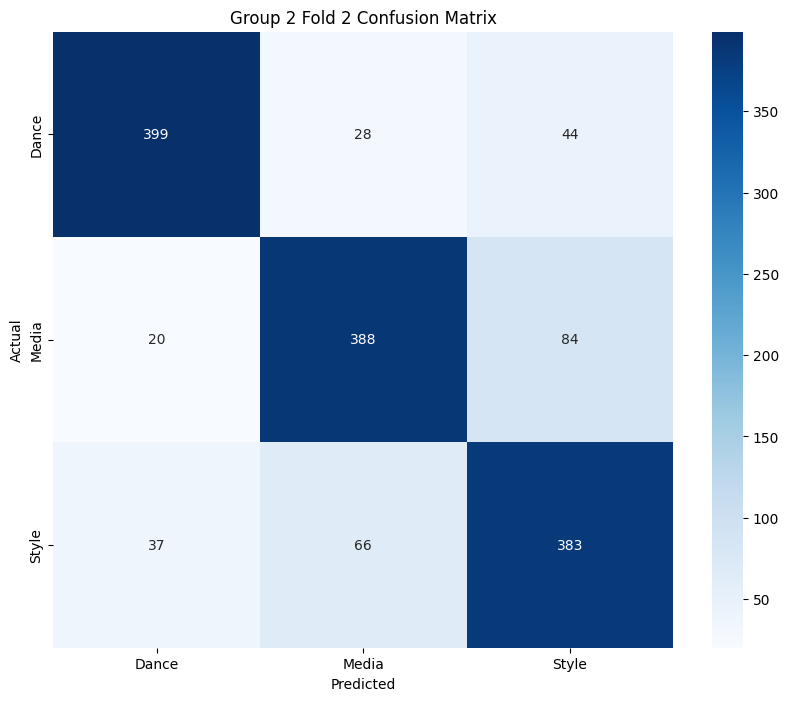

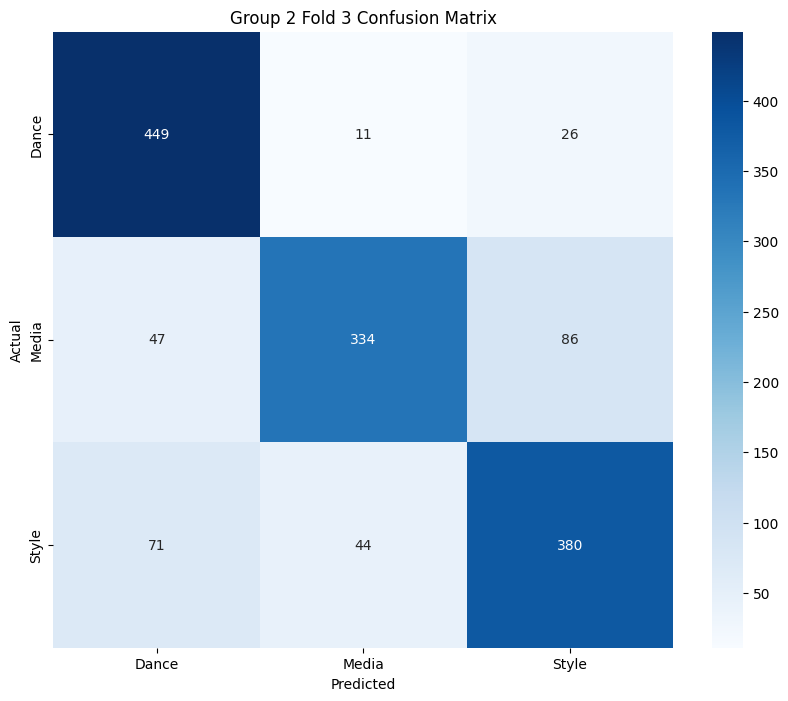

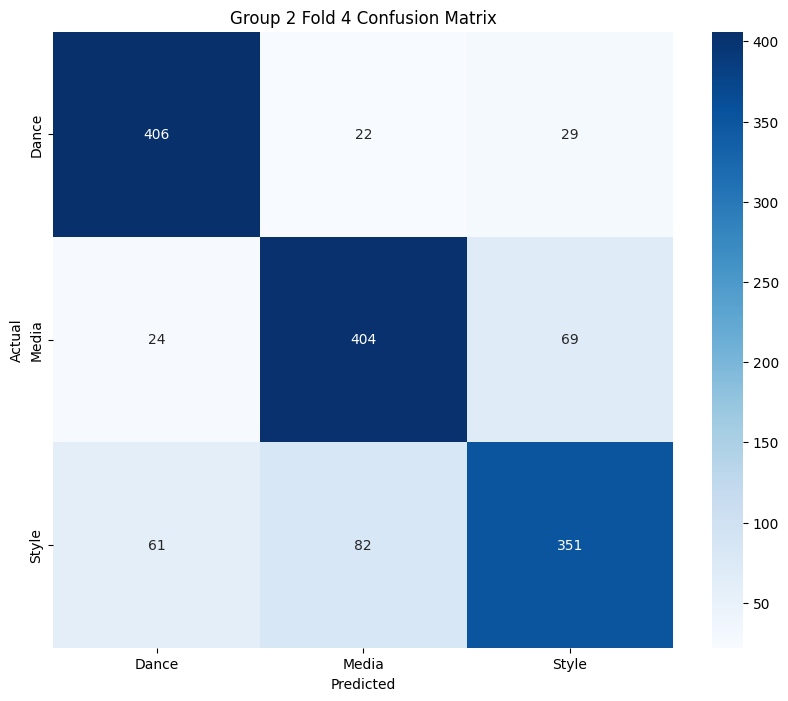

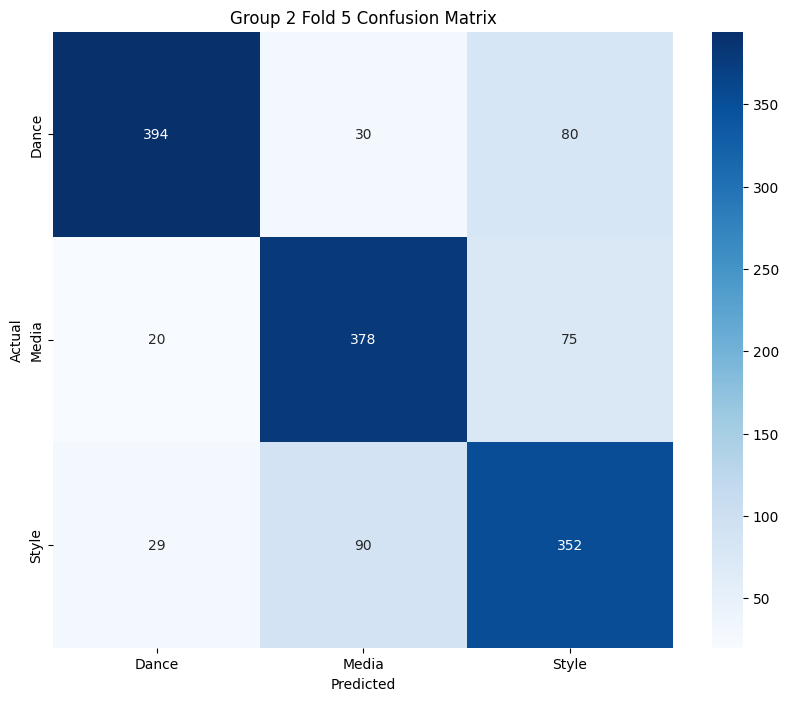

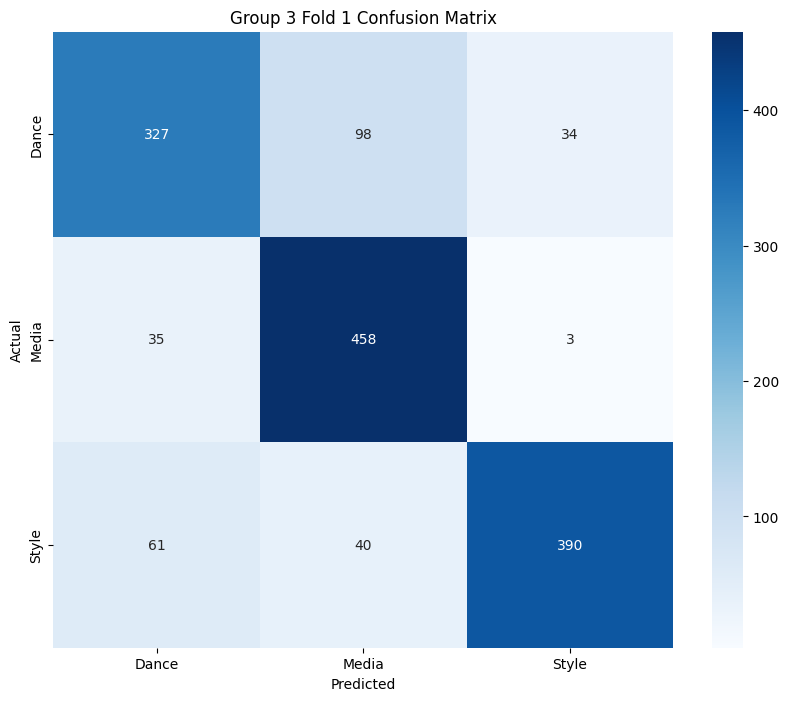

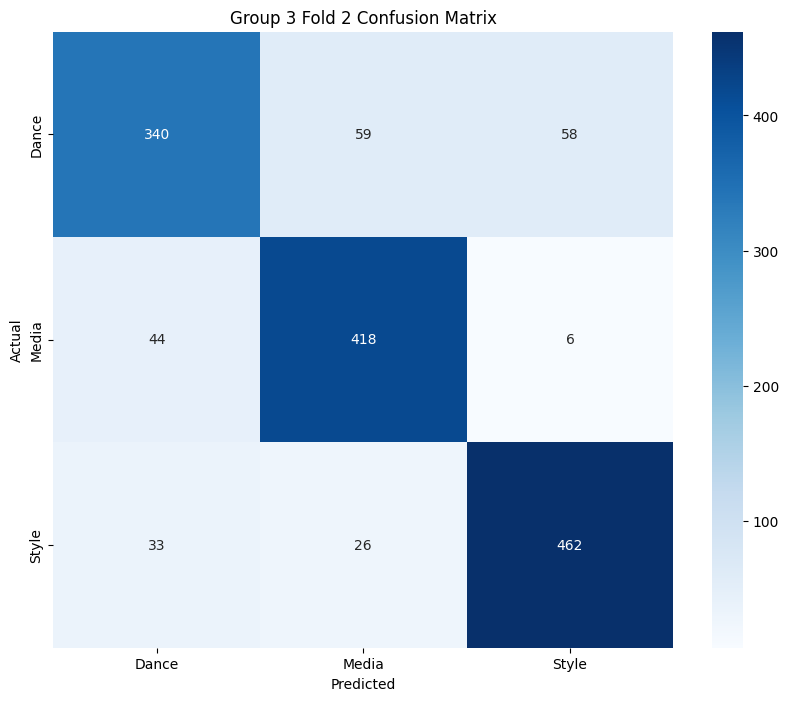

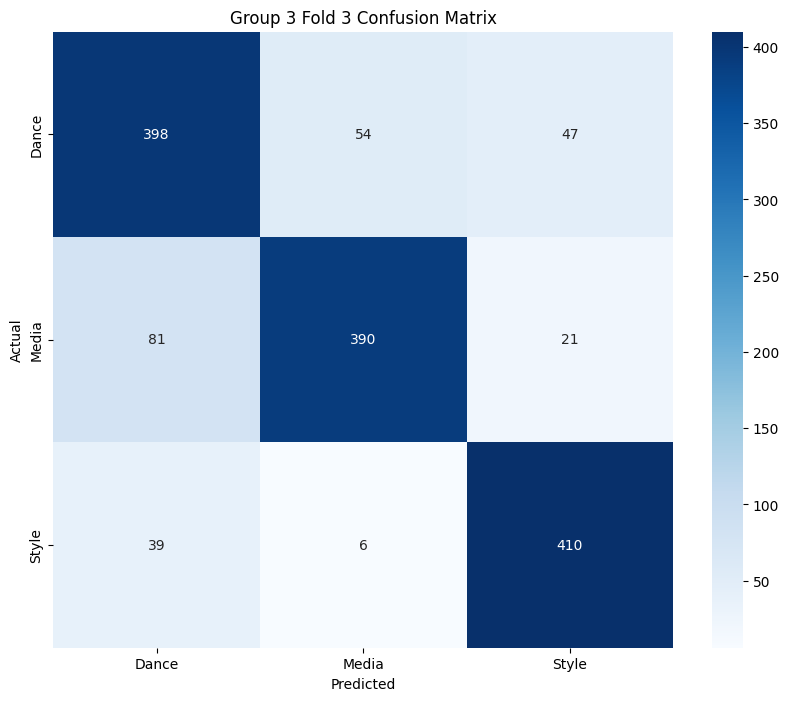

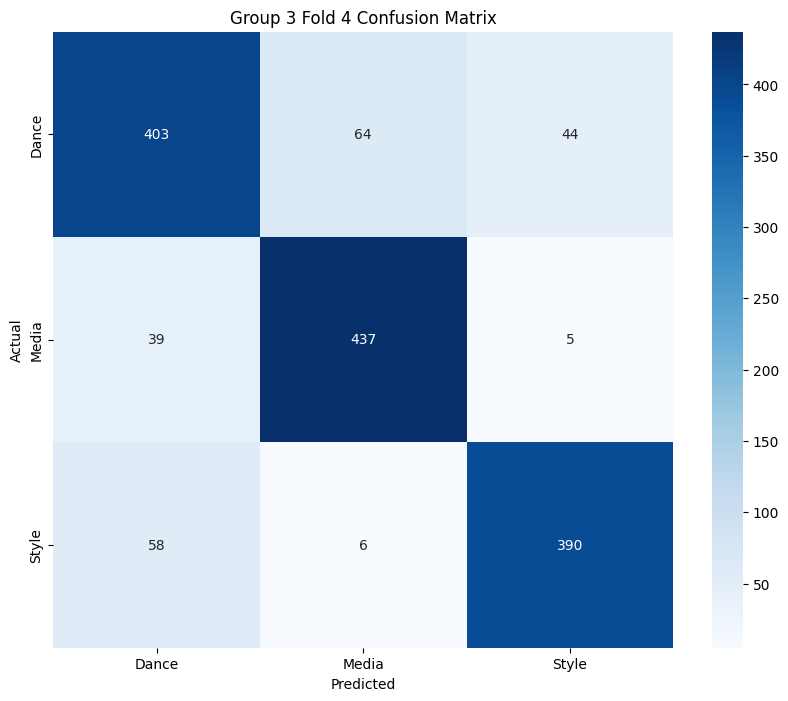

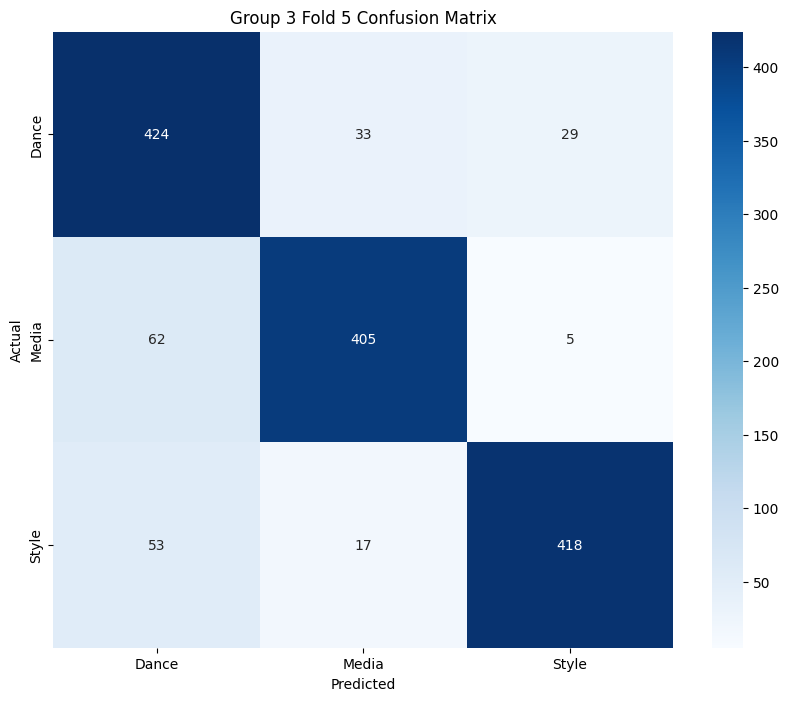

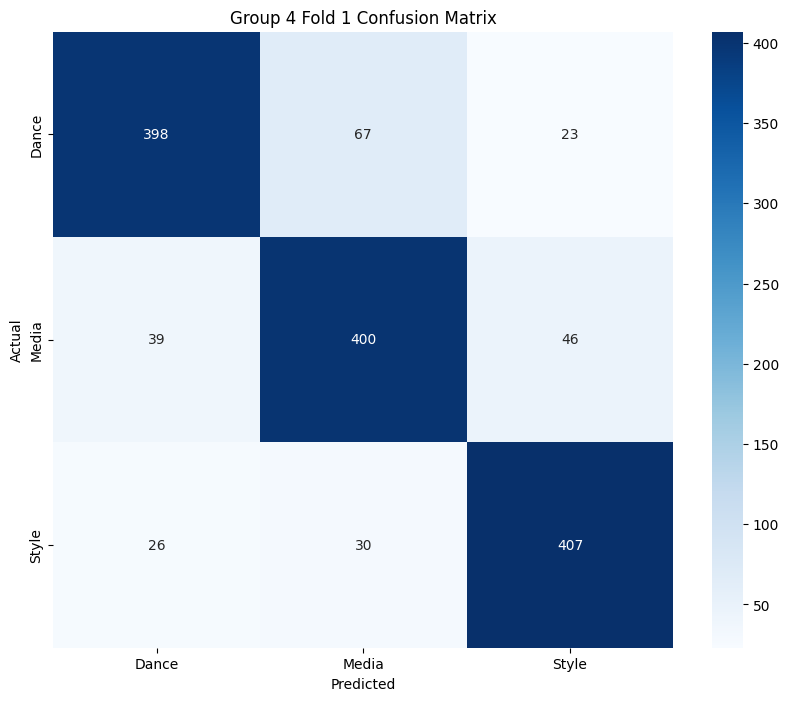

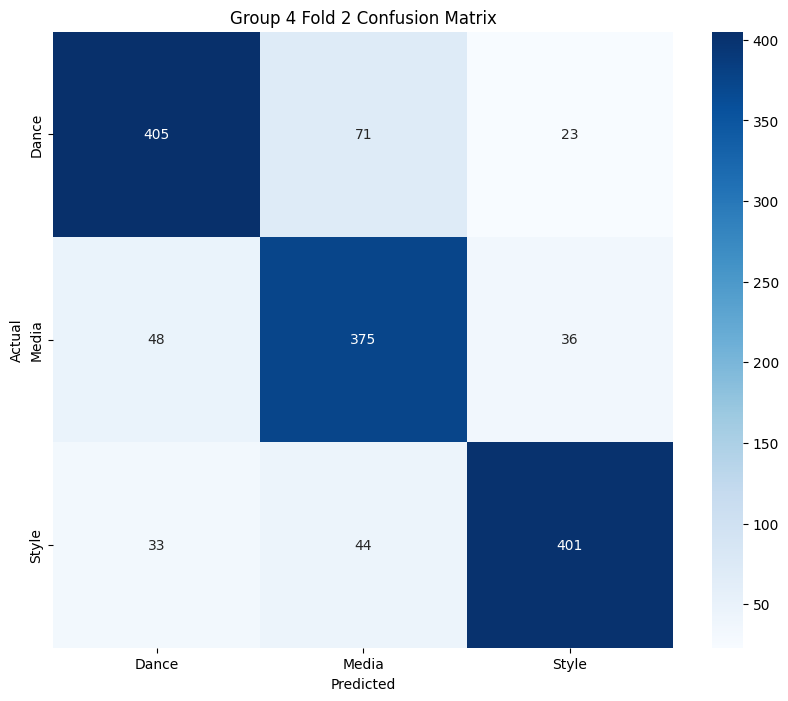

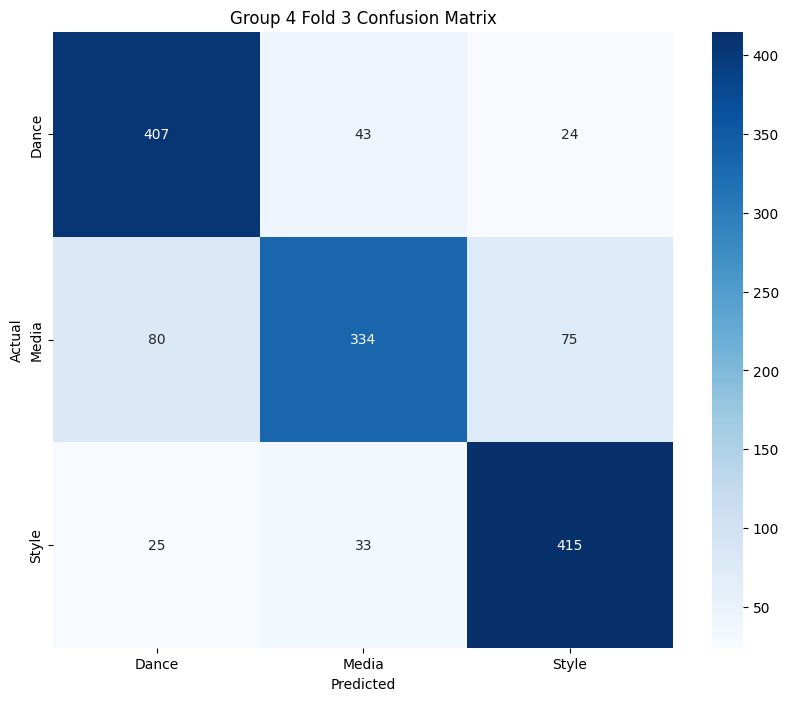

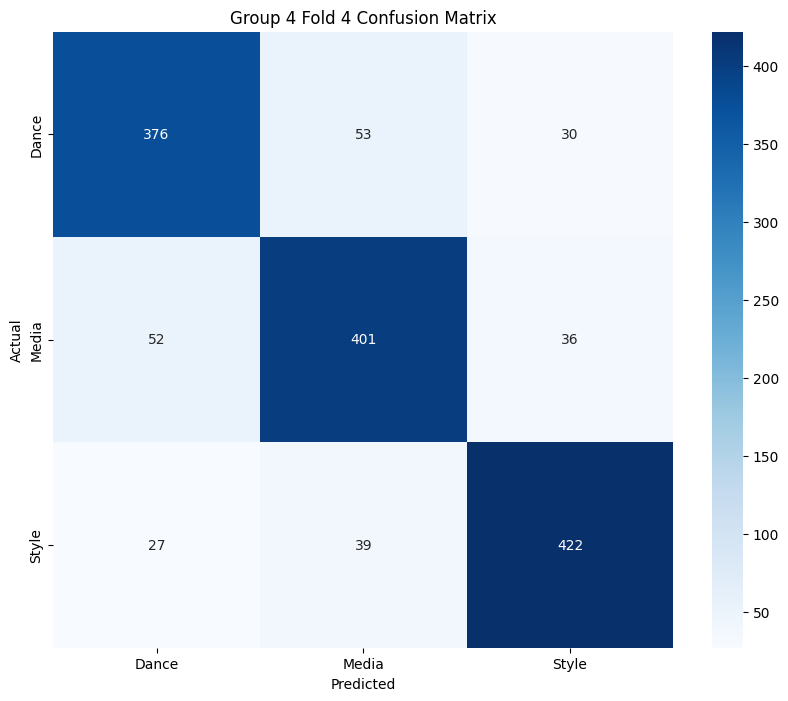

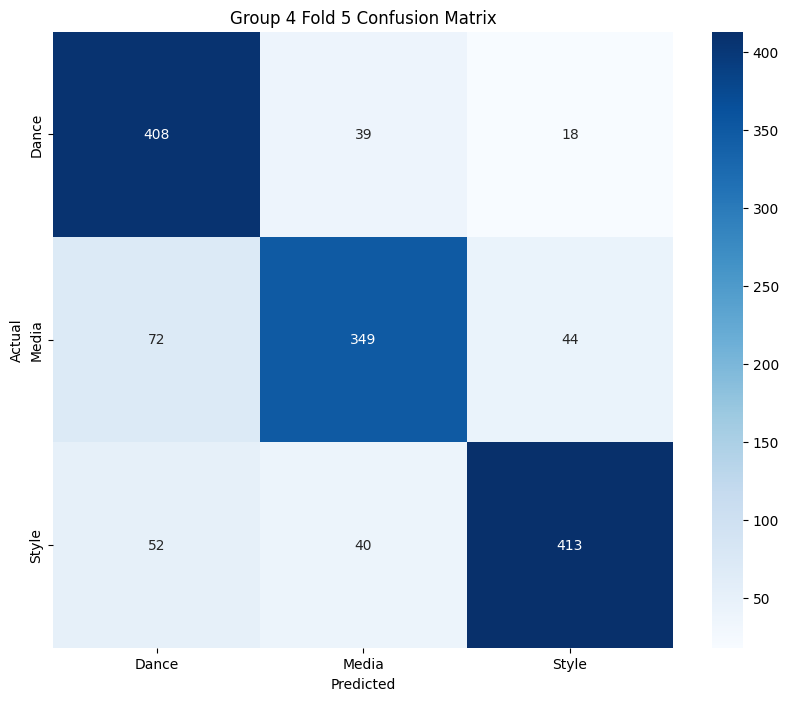

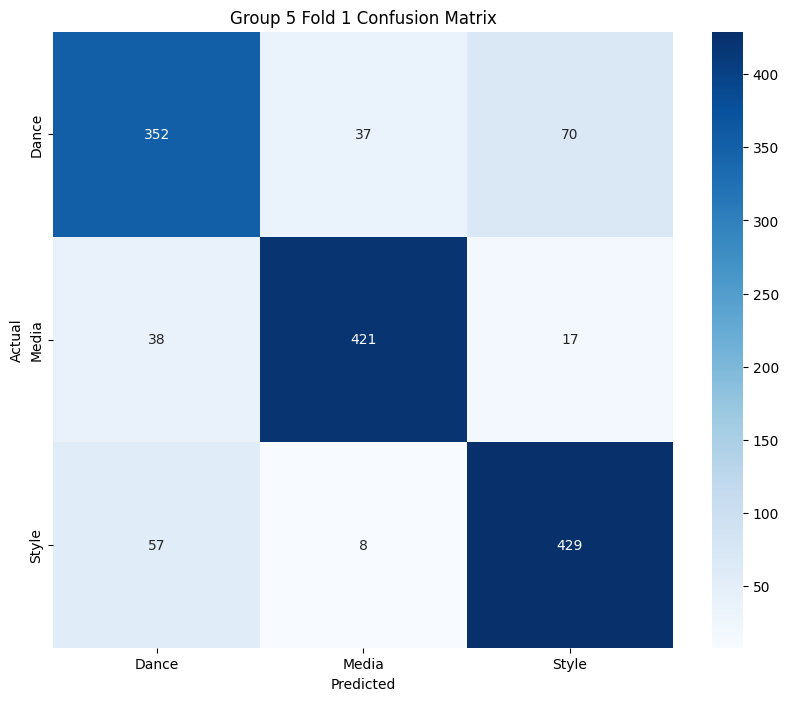

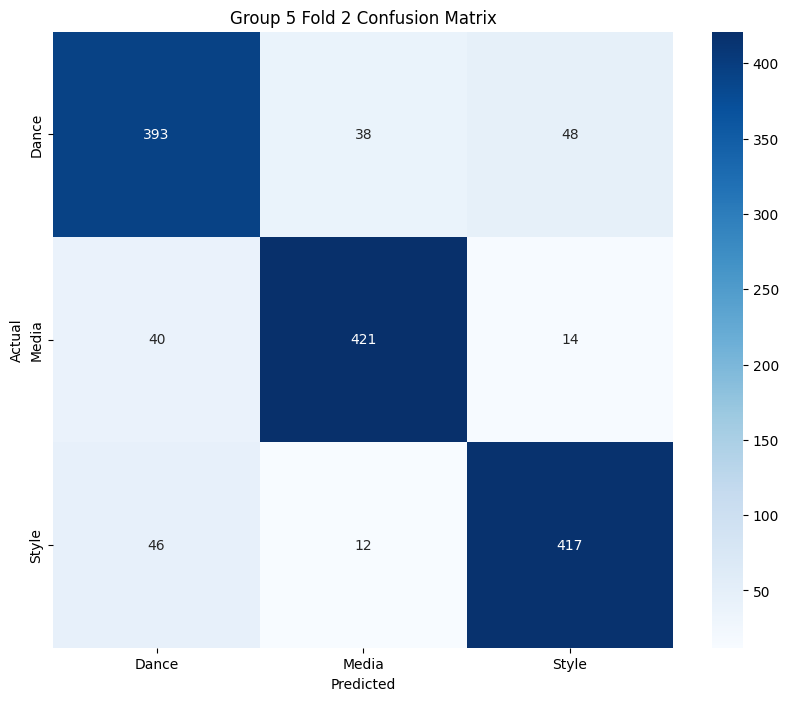

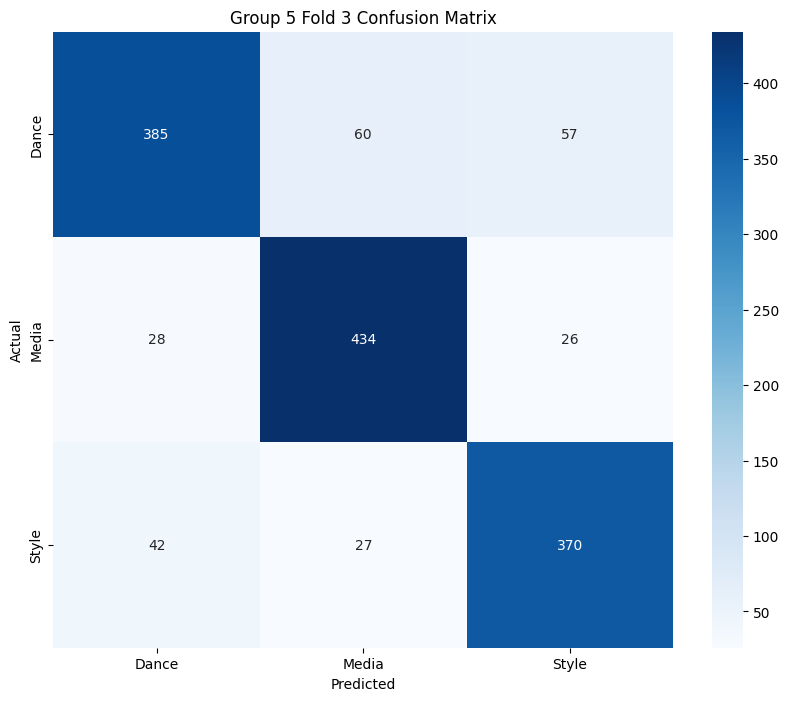

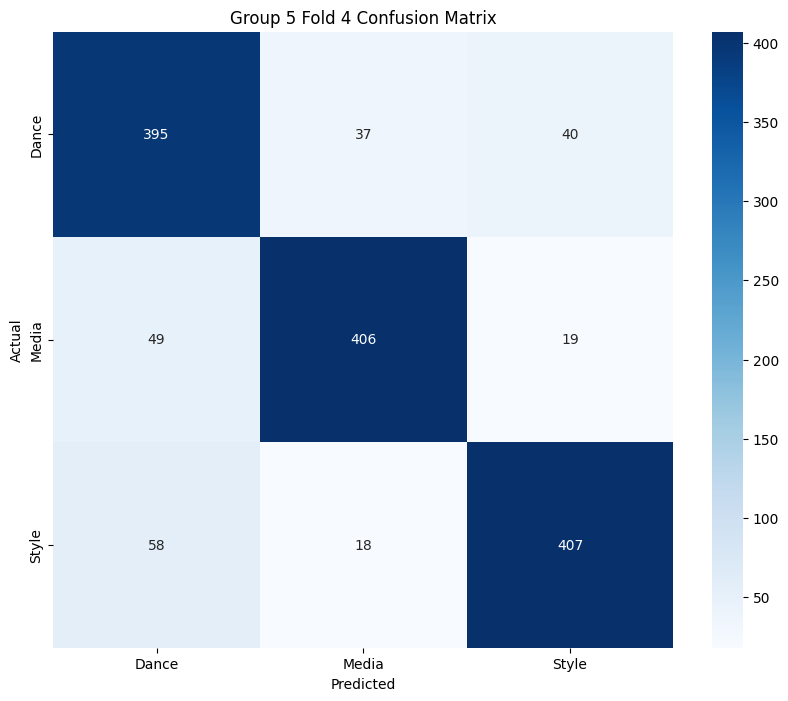

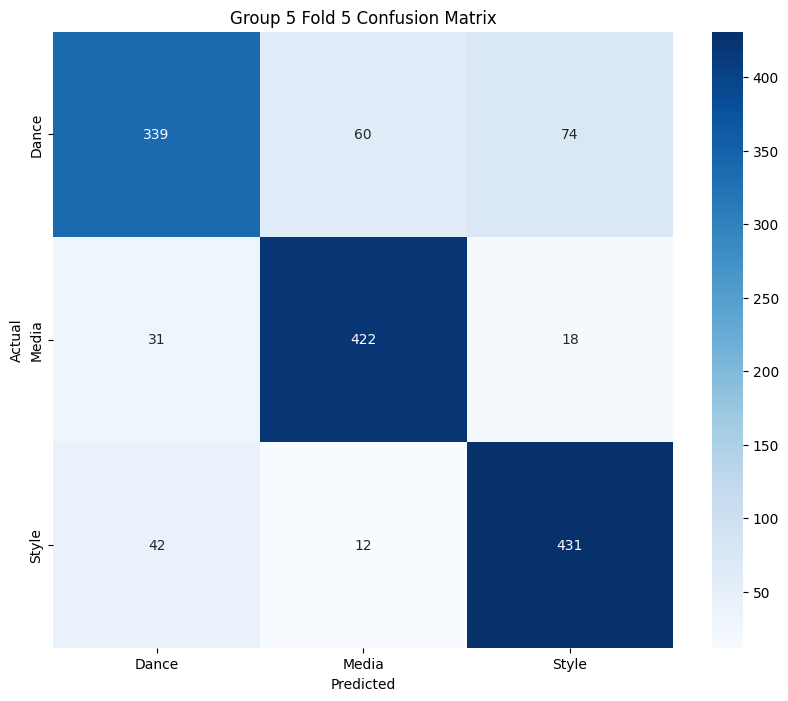

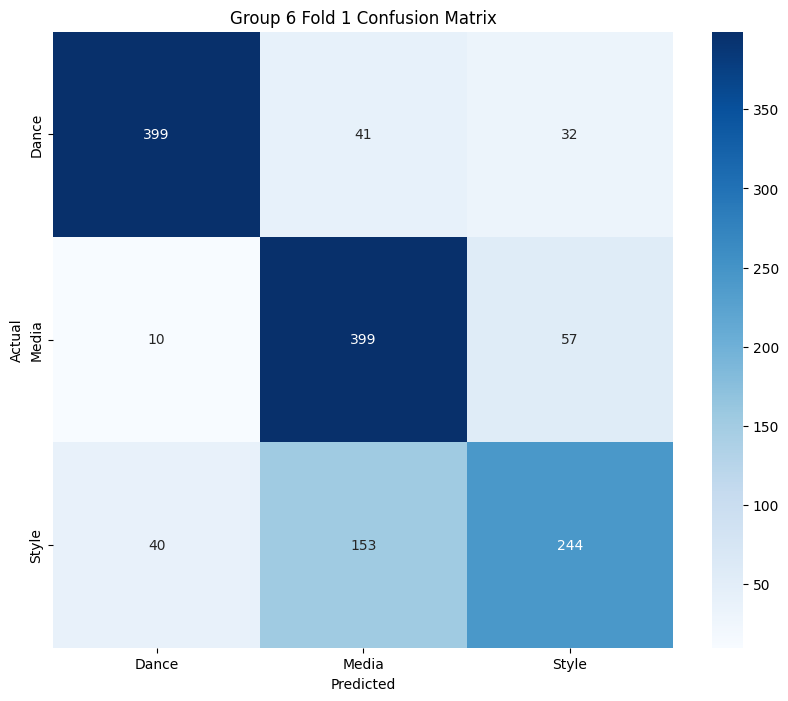

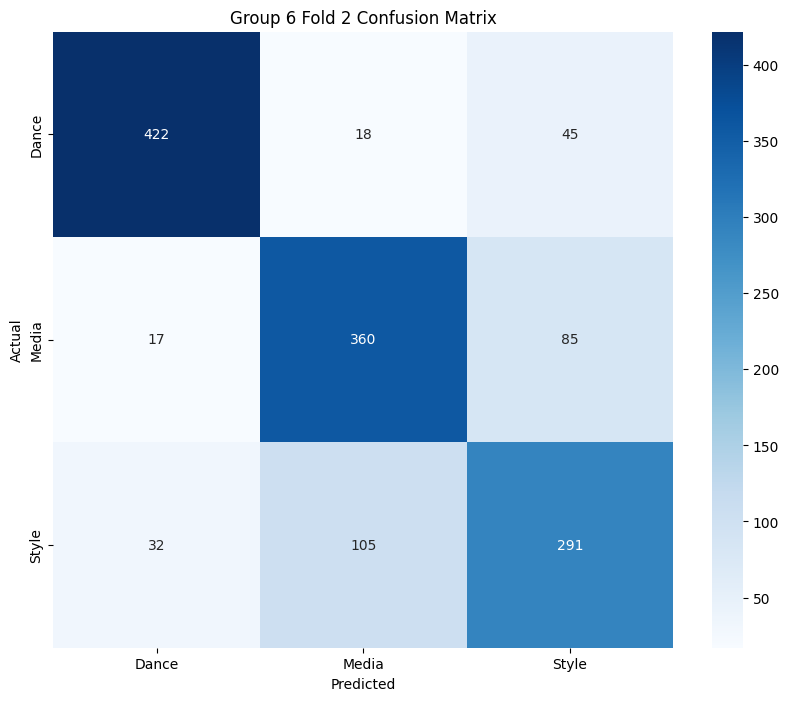

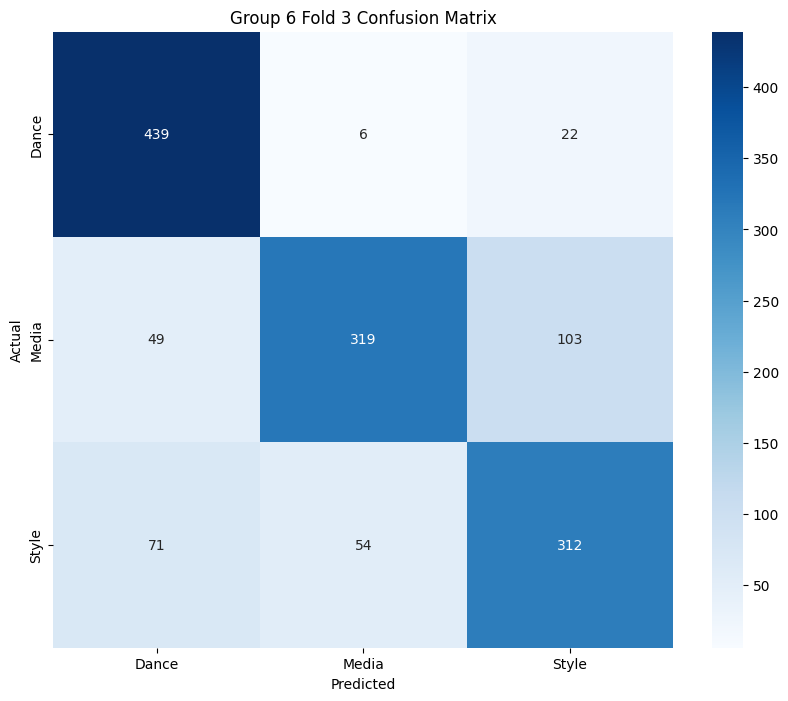

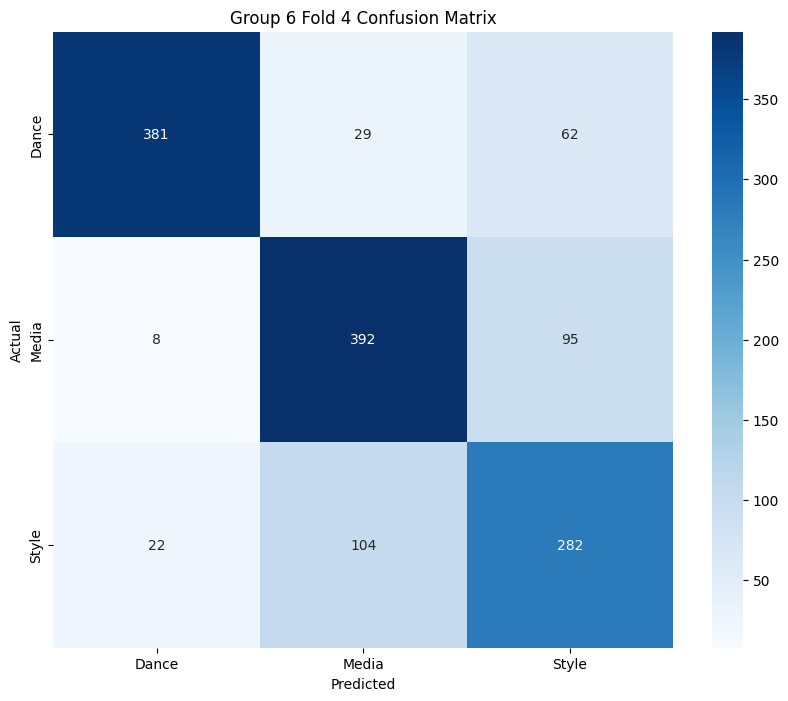

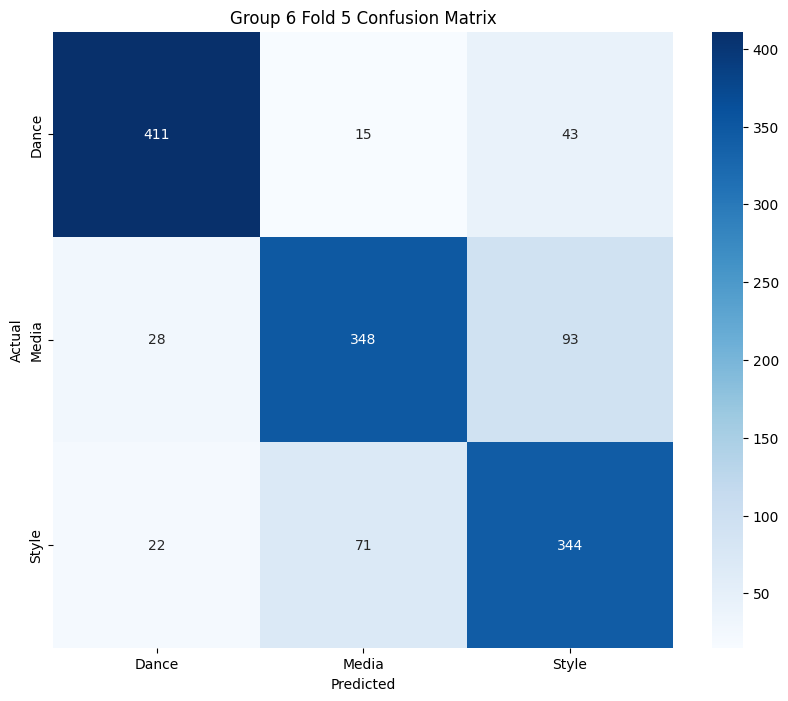

In [16]:
for result in results:
    group_idx, fold_idx = result["Group"], result["Fold"]
    cm = result["Confusion Matrix"]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title(f"Group {group_idx} Fold {fold_idx} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
